In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import sklearn
import pytorch_lightning as pl
import warnings
from pytorch_lightning.loggers import MLFlowLogger
from pytorch_lightning.loggers.base import LightningLoggerBase
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from torch import nn
from torch.utils.data import DataLoader
from typing import Optional, List, Dict, Any, Callable

warnings.filterwarnings("ignore")
pl.utilities.seed.seed_everything(42)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

Global seed set to 42


In [2]:
def normalize(data):
    scaler = MinMaxScaler()
    return scaler.fit_transform(data)

def standarize(data):
    scaler = StandardScaler()
    return scaler.fit_transform(data)

# Load Data

In [3]:
class PimaIndiansDataModule(pl.LightningDataModule):
    def __init__(self, data_dir: str = "data/diabetes.csv", train_batch_size: int = 64, val_batch_size: int = 64, transforms: List[Callable] = [], no_batch: bool = False):
        super().__init__()
        self.data_dir = data_dir
        self.train_batch_size = train_batch_size
        self.val_batch_size = val_batch_size
        self.no_batch = no_batch
        self.transforms = transforms
        
    def prepare_data(self):
        self.full_data = pd.read_csv('data/diabetes.csv')
        #self.full_data = self.full_data.drop(['Age'], axis=1)
        X = self.full_data.values[:, :-1]
        y = self.full_data.values[:, -1]
        for transform in self.transforms:
            X = transform(X)
        self.transformed_data = X
            
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)
        X_train = torch.tensor(X_train).float()
        X_test = torch.tensor(X_test).float()
        y_train = torch.tensor(y_train).long()
        y_test = torch.tensor(y_test).long()
        
        self.train_data = (X_train, y_train)
        self.test_data = (X_test, y_test)
    
    def setup(self, stage: Optional[str] = None):
        if stage == 'fit' or stage is None:
            X_train, y_train = self.train_data
            X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train)
            self.train_data = []
            self.val_data = []
            for x, y in zip(X_train, y_train):
                self.train_data.append((x, y))
                
            for x, y in zip(X_val, y_val):
                self.val_data.append((x, y))
            
            if self.no_batch:
                self.train_batch_size = len(self.train_data)
                self.val_batch_size = len(self.val_data)
        
        if stage == 'test' or stage is None:
            X_test, y_test = self.test_data
            self.test_data = []
            for x, y in zip(X_test, y_test):
                self.test_data.append((x, y))

    def train_dataloader(self):
        return DataLoader(self.train_data, self.train_batch_size, shuffle=True, num_workers=1, pin_memory=True)
    
    def val_dataloader(self):
        return DataLoader(self.val_data, self.val_batch_size, shuffle=False, num_workers=1, pin_memory=True)
    
    def test_dataloader(self):
        return DataLoader(self.test_data, shuffle=False, num_workers=1, pin_memory=True)

In [4]:
datamodule = PimaIndiansDataModule(no_batch=True, transforms=[normalize])
datamodule.prepare_data()

In [5]:
pca = PCA()
values = pca.fit_transform(datamodule.transformed_data)

8

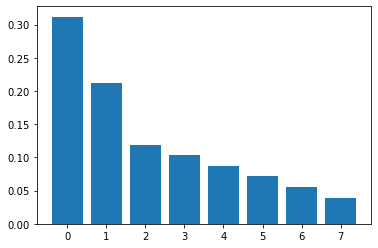

In [6]:
heights = pca.explained_variance_ratio_
gen = iter(range(0, 9, 1))
labels = [next(gen) for _ in heights]
plt.bar(labels, heights)
len(heights)

In [7]:
datamodule.full_data.head(5)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.600,0.627,50,1
1,1,85,66,29,0,26.600,0.351,31,0
2,8,183,64,0,0,23.300,0.672,32,1
3,1,89,66,23,94,28.100,0.167,21,0
4,0,137,40,35,168,43.100,2.288,33,1


In [8]:
datamodule.full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [9]:
datamodule.full_data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000,768.000,768.000,768.000,768.000,768.000,768.000,768.000,768.000
mean,3.845,120.895,69.105,20.536,79.799,31.993,0.472,33.241,0.349
std,3.370,31.973,19.356,15.952,115.244,7.884,0.331,11.760,0.477
min,0.000,0.000,0.000,0.000,0.000,0.000,0.078,21.000,0.000
25%,1.000,99.000,62.000,0.000,0.000,27.300,0.244,24.000,0.000
50%,3.000,117.000,72.000,23.000,30.500,32.000,0.372,29.000,0.000
75%,6.000,140.250,80.000,32.000,127.250,36.600,0.626,41.000,1.000
max,17.000,199.000,122.000,99.000,846.000,67.100,2.420,81.000,1.000


In [10]:
one_class = sum(datamodule.full_data.values[:, -1])
zero_class = datamodule.full_data['Outcome'].size - one_class
print(f'Class 0: {zero_class}')
print(f'Class 1: {one_class}')

Class 0: 500.0
Class 1: 268.0


# Visualisation

In [11]:
def plot_hist(data, x, y, figsize=(13, 13), bins=15):
    fig, ax = plt.subplots(x, y, figsize=figsize)
    for i in range(data.transformed_data.shape[1]):
        ax[int(i / y), i % y].hist(data.transformed_data[:, i], bins=bins)
        ax[int(i / y), i % y].set_title(data.full_data.columns[i])
    plt.show()

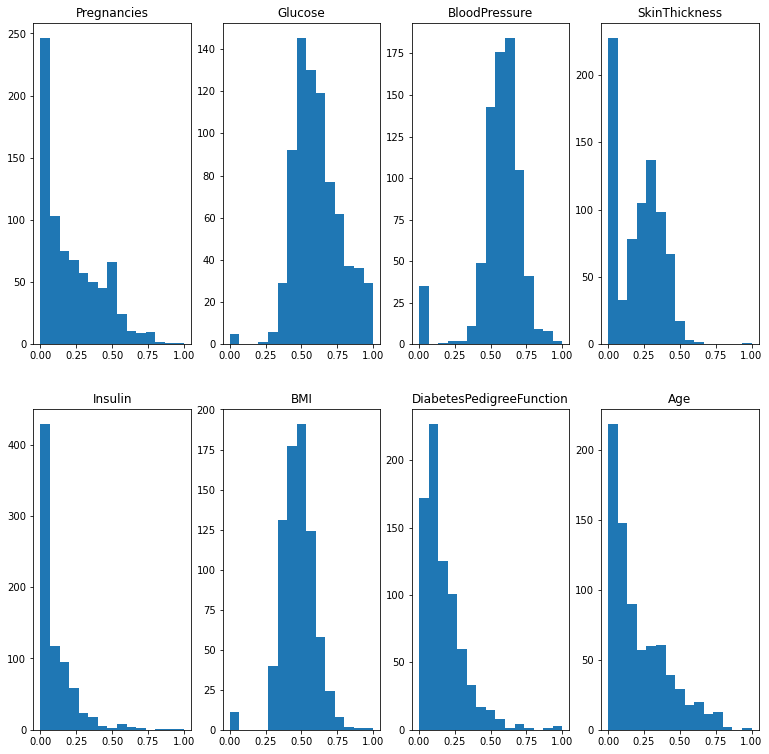

In [12]:
plot_hist(datamodule, 2, 4)

# Models

In [13]:
class Classifier(pl.LightningModule):
    def __init__(self, model, lr=1e-4):
        super().__init__()
        self.model = model
        self.lr = lr
    
    def forward(self, x):
        return self.model.forward(x)
        
    def shared_step(self, batch):
        x, y = batch
        pred = self(x)
        criterion = nn.CrossEntropyLoss()
        loss = criterion(pred, y)
        return pred, loss
        
    def training_step(self, train_batch, batch_idx):
        pred, loss = self.shared_step(train_batch)
        _, predicted = torch.max(pred.data, 1)
        _, y = train_batch
        return {'loss': loss, 'train_score': (predicted, y)}
    
    def training_epoch_end(self, outputs):
        loss = [output['loss'] for output in outputs]
        loss_nd = np.double(loss[-1].detach().cpu().numpy())
        
        results = [x['train_score'] for x in outputs]
        preds = []
        y = []
        for predicted, y_data in results:
            predicted = predicted.detach().cpu().numpy()
            y_data = y_data.detach().cpu().numpy()
            preds.extend(predicted)
            y.extend(y_data)
        f1 = f1_score(y, preds)
        self.log('loss', loss_nd, logger=True)
        self.log('train_f1', f1, prog_bar=True, logger=True)
    
    def validation_step(self, val_batch, val_batch_idx):
        pred, loss = self.shared_step(val_batch)
        _, predicted = torch.max(pred.data, 1)
        _, y = val_batch
        return {'val_loss': loss, 'val_score': (predicted, y)}
    
    def validation_epoch_end(self, outputs):
        results = [x['val_score'] for x in outputs]
        preds = []
        y = []
        for predicted, y_data in results:
            predicted = predicted.detach().cpu().numpy()
            y_data = y_data.detach().cpu().numpy()
            preds.extend(predicted)
            y.extend(y_data)
        f1 = f1_score(y, preds)
        self.log('val_f1', f1, prog_bar=True, logger=True)
        
    def test_step(self, test_batch, test_batch_idx):
        pred, loss = self.shared_step(test_batch)
        _, predicted = torch.max(pred.data, 1)
        _, y = test_batch
        return {'test_loss': loss, 'test_score': (predicted, y)}
    
    def test_epoch_end(self, outputs):
        results = [x['test_score'] for x in outputs]
        preds = []
        y = []
        for predicted, y_data in results:
            predicted = predicted.detach().cpu().numpy()
            y_data = y_data.detach().cpu().numpy()
            preds.extend(predicted)
            y.extend(y_data)
        acc = accuracy_score(y, preds)
        f1 = f1_score(y, preds)
        self.log('accuracy', acc, prog_bar=True, logger=True)
        self.log('f1', f1, prog_bar=True, logger=True)
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
        return [optimizer], [scheduler]

In [14]:
class SpreadNNNoPool(pl.LightningModule):
    def __init__(self, in_size, out_size):
        super().__init__()
        
        self._nn = nn.Sequential(
            nn.Linear(in_size, in_size * 2),
            nn.BatchNorm1d(in_size * 2),
            nn.LeakyReLU(),
            
            nn.Linear(in_size * 2, in_size * 4),
            nn.BatchNorm1d(in_size * 4),
            nn.LeakyReLU(),
            
            nn.Linear(in_size * 4, in_size * 2),
            nn.BatchNorm1d(in_size * 2),
            nn.LeakyReLU(),
            
            nn.Linear(in_size * 2, int(in_size / 2)),
            nn.BatchNorm1d(int(in_size / 2)),
            nn.LeakyReLU(),
            
            nn.Linear(int(in_size / 2), out_size)
        )
        
        self.name = 'spreadnn_no_pool.ckpt'
    
    def forward(self, x):
        return self._nn(x)

In [15]:
class SpreadNNNoPoolBig(pl.LightningModule):
    def __init__(self, in_size, out_size):
        super().__init__()
        
        in_size_2 = in_size * 2
        in_size_4 = in_size * 4
        in_size_8 = in_size * 8
        in_size_16 = in_size * 16
        self._nn = nn.Sequential(
            nn.Linear(in_size, in_size_4),
            nn.BatchNorm1d(in_size_4),
            nn.LeakyReLU(),
            
            nn.Linear(in_size_4, in_size_16),
            nn.BatchNorm1d(in_size_16),
            nn.LeakyReLU(),
            
            nn.Linear(in_size_16, in_size_8),
            nn.BatchNorm1d(in_size_8),
            nn.LeakyReLU(),
            
            nn.Linear(in_size_8, in_size_4),
            nn.BatchNorm1d(in_size_4),
            nn.LeakyReLU(),
            
            nn.Linear(in_size_4, in_size),
            nn.BatchNorm1d(in_size),
            nn.LeakyReLU(),
            
            nn.Linear(in_size, out_size)
        )
        
        self.name = 'spreadnn_no_pool_big.ckpt'
    
    def forward(self, x):
        return self._nn(x)

In [16]:
class SpreadNNNoPoolGigaBig(pl.LightningModule):
    def __init__(self):
        super().__init__()
        
        self._nn = nn.Sequential(
            nn.Linear(8, 32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(),
            
            nn.Linear(32, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(),
            
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(),
            
            nn.Linear(32, 8),
            nn.BatchNorm1d(8),
            nn.LeakyReLU(),
            
            nn.Linear(8, 2)
        )
        
        self.name = 'spreadnn_no_pool_giga_big.ckpt'
    
    def forward(self, x):
        return self._nn(x)

In [17]:
class SpreadNNNoPoolDoubleBig(pl.LightningModule):
    def __init__(self, in_size, out_size):
        super().__init__()
        
        in_size_2 = in_size * 2
        in_size_4 = in_size * 4
        in_size_8 = in_size * 8
        in_size_16 = in_size * 16
        self._nn = nn.Sequential(
            nn.Linear(in_size, in_size_4),
            nn.BatchNorm1d(in_size_4),
            nn.LeakyReLU(),
            
            nn.Linear(in_size_4, in_size_16),
            nn.BatchNorm1d(in_size_16),
            nn.LeakyReLU(),
            
            nn.Linear(in_size_16, in_size_16),
            nn.BatchNorm1d(in_size_16),
            nn.LeakyReLU(),
            
            nn.Linear(in_size_16, in_size_8),
            nn.BatchNorm1d(in_size_8),
            nn.LeakyReLU(),
            
            nn.Linear(in_size_8, in_size_4),
            nn.BatchNorm1d(in_size_4),
            nn.LeakyReLU(),
            
            nn.Linear(in_size_4, in_size),
            nn.BatchNorm1d(in_size),
            nn.LeakyReLU(),
            
            nn.Linear(in_size, out_size)
        )
        
        self.name = 'spreadnn_no_pool_double_big.ckpt'
    
    def forward(self, x):
        return self._nn(x)

In [18]:
class SpreadNNSmall(pl.LightningModule):
    def __init__(self):
        super().__init__()
        
        self._nn = nn.Sequential(
            nn.Linear(8, 16),
            nn.BatchNorm1d(16),
            nn.LeakyReLU(),
            
            nn.Linear(16, 8),
            nn.BatchNorm1d(8),
            nn.LeakyReLU(),
            
            nn.Linear(8, 4),
            nn.BatchNorm1d(4),
            nn.LeakyReLU(),
            
            nn.Linear(4, 2)
        )
        
        self.name = 'spreadnn_small.ckpt'
    
    def forward(self, x):
        return self._nn(x)

# Evaluation

In [19]:
def generate(elem, count, step):
    current = elem
    output = []
    for _ in range(count):
        output.append(current)
        current += step
    return output

In [20]:
class Evaluator:
    def __init__(self, models: List[pl.LightningModule], version: str, trainer_params: Dict[str, Any] = {}, logger: LightningLoggerBase = MLFlowLogger, logger_params: Dict[str, Any] = {},
                 callbacks=[], callback_params={}):
        self.models = models
        self.classifiers = [Classifier(model) for model in models]
        self.version = version
        self.paths = ['model/' + version + model.name for model in models]
        self.loggers = [logger(**logger_params) for _ in models]
        self.callbacks = []
        for _ in models:
            self.callbacks.append([callback(**callback_params) for callback in callbacks])
        self.trainer_params = trainer_params
    
    def train(self, min_lr: float, datamodule: pl.LightningDataModule, transforms: List[Callable], find_lr: bool = True, verbose: bool = False):
        for path, classifier, logger, callback in zip(self.paths, self.classifiers, self.loggers, self.callbacks):
            self.trainer = pl.Trainer(logger=logger, callbacks=callback, **self.trainer_params)
            if find_lr:
                lr_finder = self.trainer.tuner.lr_find(classifier, min_lr=min_lr, datamodule=datamodule(no_batch=True, transforms=transforms), early_stop_threshold=None)
                classifier.lr = lr_finder.suggestion()
            else:
                classifier.lr = min_lr

            if verbose and find_lr:
                print(f'Best lr: {classifier.lr}')

            self.trainer.fit(classifier, datamodule(no_batch=True, transforms=transforms))
            self.trainer.save_checkpoint(path)
    
    def test(self, datamodule: pl.LightningDataModule, transforms: List[Callable]):
        for path, model, logger in zip(self.paths, self.models, self.loggers):
            self.trainer = pl.Trainer(logger=logger, **self.trainer_params)
            classifier = Classifier.load_from_checkpoint(path, model=model)
            self.trainer.test(classifier, datamodule=datamodule(no_batch=True, transforms=transforms))

In [21]:
class LinearSearch:
    def __init__(self, grid_params, combinations):
        self.grid_params = grid_params
        self.combinations = combinations
    
    def search(self, models, in_size, out_size, datamodule, versions, min_lr, transforms, find_lr, verbose, callbacks=[], callback_params={}):
        for i in range(self.combinations):
            obj_models = [model(in_size, out_size) for model in models]
            params = {}
            for key in self.grid_params.keys():
                params[key] = self.grid_params[key][i]
            print(params)
            evaluator = Evaluator(obj_models, versions[i], params, callbacks=callbacks, callback_params=callback_params)
            evaluator.train(min_lr, datamodule, transforms, find_lr=find_lr, verbose=verbose)
            evaluator.test(datamodule, transforms)

In [24]:
models = [SpreadNNNoPoolBig, SpreadNNNoPoolDoubleBig]
min_lr = 1e-03
in_size = 8
out_size = 2
datamodule = PimaIndiansDataModule
transforms = [normalize]
early_stopping_params = {'monitor': 'loss', 'min_delta': 0.001, 'patience': 6}
callbacks = [EarlyStopping]
params_count = 9
params = {
    'gpus': generate(1, params_count, 0),
    'max_epochs': [20, 30, 35, 40, 45, 50, 60, 75, 100],
    'gradient_clip_val': generate(0.5, params_count, 0.),
    'stochastic_weight_avg': generate(True, params_count, False),
    'amp_level': generate('O3', params_count, ''),
    'precision': generate(16, params_count, 0)
}
versions = [str(max_epoch) + 'epoch_' for max_epoch in params['max_epochs']]
print(versions)

['20epoch_', '30epoch_', '35epoch_', '40epoch_', '45epoch_', '50epoch_', '60epoch_', '75epoch_', '100epoch_']


In [ ]:
for i in range(10):
    linear_search = LinearSearch(params, params_count)
    loop_versions = [str(i) + '_' + version for version in versions]
    linear_search.search(models, in_size, out_size, datamodule, loop_versions, min_lr, transforms, False, False, callbacks, early_stopping_params)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


{'gpus': 1, 'max_epochs': 20, 'gradient_clip_val': 0.5, 'stochastic_weight_avg': True, 'amp_level': 'O3', 'precision': 16}



  | Name  | Type              | Params
--------------------------------------------
0 | model | SpreadNNNoPoolBig | 15.7 K
--------------------------------------------
15.7 K    Trainable params
0         Non-trainable params
15.7 K    Total params
0.063     Total estimated model params size (MB)


Global seed set to 42


Epoch 0:  50%|███████████████████                   | 1/2 [00:02<00:02,  2.23s/it, loss=0.78, v_num=0e06, val_f1=0.521]
Validating: 0it [00:00, ?it/s]
Epoch 1:  50%|██████████▌          | 1/2 [00:02<00:02,  2.09s/it, loss=0.742, v_num=0e06, val_f1=0.521, train_f1=0.502]
Validating: 0it [00:00, ?it/s]
Epoch 2:  50%|██████████▌          | 1/2 [00:02<00:02,  2.21s/it, loss=0.716, v_num=0e06, val_f1=0.521, train_f1=0.532]
Validating: 0it [00:00, ?it/s]
Epoch 3:  50%|██████████▌          | 1/2 [00:02<00:02,  2.03s/it, loss=0.697, v_num=0e06, val_f1=0.521, train_f1=0.560]
Validating: 0it [00:00, ?it/s]
Epoch 4:  50%|██████████▌          | 1/2 [00:02<00:02,  2.07s/it, loss=0.682, v_num=0e06, val_f1=0.521, train_f1=0.596]
Validating: 0it [00:00, ?it/s]
Epoch 5:  50%|██████████▌          | 1/2 [00:02<00:02,  2.08s/it, loss=0.669, v_num=0e06, val_f1=0.521, train_f1=0.618]
Validating: 0it [00:00, ?it/s]
Epoch 6:  50%|██████████▌          | 1/2 [00:02<00:02,  2.25s/it, loss=0.658, v_num=0e06, val_

Swapping scheduler <torch.optim.lr_scheduler.ExponentialLR object at 0x000002062D2317C0> for <torch.optim.swa_utils.SWALR object at 0x000002062CE4C070>


Epoch 15:  50%|██████████          | 1/2 [00:02<00:02,  2.13s/it, loss=0.595, v_num=0e06, val_f1=0.521, train_f1=0.744]
Validating: 0it [00:00, ?it/s]
Epoch 16:  50%|██████████▌          | 1/2 [00:02<00:02,  2.12s/it, loss=0.59, v_num=0e06, val_f1=0.521, train_f1=0.746]
Validating: 0it [00:00, ?it/s]
Epoch 17:  50%|██████████          | 1/2 [00:02<00:02,  2.14s/it, loss=0.586, v_num=0e06, val_f1=0.521, train_f1=0.758]
Validating: 0it [00:00, ?it/s]
Epoch 18:  50%|██████████          | 1/2 [00:02<00:02,  2.14s/it, loss=0.581, v_num=0e06, val_f1=0.521, train_f1=0.764]
Validating: 0it [00:00, ?it/s]
Epoch 19:  50%|██████████          | 1/2 [00:02<00:02,  2.13s/it, loss=0.577, v_num=0e06, val_f1=0.521, train_f1=0.773]
Validating: 0it [00:00, ?it/s]
Epoch 20:  25%|█████               | 1/4 [00:02<00:06,  2.14s/it, loss=0.577, v_num=0e06, val_f1=0.528, train_f1=0.779]
Validating: 0it [00:00, ?it/s]
Epoch 20:  75%|███████████████     | 3/4 [00:02<00:00,  1.06it/s, loss=0.577, v_num=0e06, val_

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                    | Params
--------------------------------------------------
0 | model | SpreadNNNoPoolDoubleBig | 32.4 K
--------------------------------------------------
32.4 K    Trainable params
0         Non-trainable params
32.4 K    Total params
0.130     Total estimated model params size (MB)


Global seed set to 42


Epoch 0:  50%|██████████████████▌                  | 1/2 [00:02<00:02,  2.20s/it, loss=0.727, v_num=d1e8, val_f1=0.000]
Validating: 0it [00:00, ?it/s]
Epoch 1:  50%|██████████▌          | 1/2 [00:02<00:02,  2.15s/it, loss=0.684, v_num=d1e8, val_f1=0.000, train_f1=0.358]
Validating: 0it [00:00, ?it/s]
Epoch 2:  50%|██████████▌          | 1/2 [00:02<00:02,  2.12s/it, loss=0.653, v_num=d1e8, val_f1=0.000, train_f1=0.550]
Validating: 0it [00:00, ?it/s]
Epoch 3:  50%|██████████▌          | 1/2 [00:02<00:02,  2.13s/it, loss=0.629, v_num=d1e8, val_f1=0.000, train_f1=0.670]
Validating: 0it [00:00, ?it/s]
Epoch 4:  50%|██████████▌          | 1/2 [00:02<00:02,  2.21s/it, loss=0.611, v_num=d1e8, val_f1=0.000, train_f1=0.720]
Validating: 0it [00:00, ?it/s]
Epoch 5:  50%|██████████▌          | 1/2 [00:02<00:02,  2.17s/it, loss=0.597, v_num=d1e8, val_f1=0.000, train_f1=0.748]
Validating: 0it [00:00, ?it/s]
Epoch 6:  50%|██████████▌          | 1/2 [00:02<00:02,  2.15s/it, loss=0.584, v_num=d1e8, val_

Swapping scheduler <torch.optim.lr_scheduler.ExponentialLR object at 0x000002063CE85040> for <torch.optim.swa_utils.SWALR object at 0x000002063CE62280>


Epoch 15:  50%|██████████          | 1/2 [00:02<00:02,  2.13s/it, loss=0.517, v_num=d1e8, val_f1=0.000, train_f1=0.865]
Validating: 0it [00:00, ?it/s]
Epoch 16:  50%|██████████          | 1/2 [00:02<00:02,  2.13s/it, loss=0.512, v_num=d1e8, val_f1=0.000, train_f1=0.871]
Validating: 0it [00:00, ?it/s]
Epoch 17:  50%|██████████          | 1/2 [00:02<00:02,  2.15s/it, loss=0.508, v_num=d1e8, val_f1=0.000, train_f1=0.871]
Validating: 0it [00:00, ?it/s]
Epoch 18:  50%|██████████          | 1/2 [00:02<00:02,  2.14s/it, loss=0.503, v_num=d1e8, val_f1=0.000, train_f1=0.874]
Validating: 0it [00:00, ?it/s]
Epoch 19:  50%|██████████          | 1/2 [00:02<00:02,  2.13s/it, loss=0.499, v_num=d1e8, val_f1=0.000, train_f1=0.877]
Validating: 0it [00:00, ?it/s]
Epoch 20:  25%|█████               | 1/4 [00:02<00:06,  2.15s/it, loss=0.499, v_num=d1e8, val_f1=0.000, train_f1=0.883]
Validating: 0it [00:00, ?it/s]
Epoch 20:  75%|███████████████     | 3/4 [00:04<00:01,  1.43s/it, loss=0.499, v_num=d1e8, val_

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing: 100%|███████████████████████████████████████████████████████████████████████| 231/231 [00:02<00:00, 92.97it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': 0.7922077922077922, 'f1': 0.7551020408163266}
--------------------------------------------------------------------------------
Testing: 100%|███████████████████████████████████████████████████████████████████████| 231/231 [00:02<00:00, 89.68it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params
--------------------------------------------
0 | model | SpreadNNNoPoolBig | 15.7 K
--------------------------------------------
15.7 K    Trainable params
0         Non-trainable params
15.7 K    Total params
0.063     Total estimated model params size (MB)



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': 0.8441558441558441, 'f1': 0.7662337662337663}
--------------------------------------------------------------------------------
{'gpus': 1, 'max_epochs': 30, 'gradient_clip_val': 0.5, 'stochastic_weight_avg': 1, 'amp_level': 'O3', 'precision': 16}
                                                                                                                       

Global seed set to 42


Epoch 0:  50%|██████████████████▌                  | 1/2 [00:02<00:02,  2.20s/it, loss=0.814, v_num=7c21, val_f1=0.521]
Validating: 0it [00:00, ?it/s]
Epoch 1:  50%|██████████▌          | 1/2 [00:02<00:02,  2.14s/it, loss=0.784, v_num=7c21, val_f1=0.521, train_f1=0.495]
Validating: 0it [00:00, ?it/s]
Epoch 2:  50%|██████████▌          | 1/2 [00:02<00:02,  2.16s/it, loss=0.761, v_num=7c21, val_f1=0.521, train_f1=0.524]
Validating: 0it [00:00, ?it/s]
Epoch 3:  50%|██████████▌          | 1/2 [00:02<00:02,  2.15s/it, loss=0.742, v_num=7c21, val_f1=0.521, train_f1=0.568]
Validating: 0it [00:00, ?it/s]
Epoch 4:  50%|██████████▌          | 1/2 [00:02<00:02,  2.13s/it, loss=0.727, v_num=7c21, val_f1=0.521, train_f1=0.587]
Validating: 0it [00:00, ?it/s]
Epoch 5:  50%|██████████▌          | 1/2 [00:02<00:02,  2.12s/it, loss=0.713, v_num=7c21, val_f1=0.521, train_f1=0.602]
Validating: 0it [00:00, ?it/s]
Epoch 6:  50%|██████████▌          | 1/2 [00:02<00:02,  2.13s/it, loss=0.702, v_num=7c21, val_

Swapping scheduler <torch.optim.lr_scheduler.ExponentialLR object at 0x000002062D202520> for <torch.optim.swa_utils.SWALR object at 0x000002062CC56070>


Epoch 23:  50%|██████████          | 1/2 [00:02<00:02,  2.04s/it, loss=0.585, v_num=7c21, val_f1=0.521, train_f1=0.748]
Validating: 0it [00:00, ?it/s]
Epoch 24:  50%|██████████          | 1/2 [00:02<00:02,  2.09s/it, loss=0.578, v_num=7c21, val_f1=0.521, train_f1=0.752]
Validating: 0it [00:00, ?it/s]
Epoch 25:  50%|██████████          | 1/2 [00:02<00:02,  2.09s/it, loss=0.573, v_num=7c21, val_f1=0.521, train_f1=0.757]
Validating: 0it [00:00, ?it/s]
Epoch 26:  50%|██████████          | 1/2 [00:02<00:02,  2.03s/it, loss=0.567, v_num=7c21, val_f1=0.521, train_f1=0.761]
Validating: 0it [00:00, ?it/s]
Epoch 27:  50%|██████████          | 1/2 [00:02<00:02,  2.04s/it, loss=0.562, v_num=7c21, val_f1=0.528, train_f1=0.766]
Validating: 0it [00:00, ?it/s]
Epoch 28:  50%|██████████          | 1/2 [00:02<00:02,  2.09s/it, loss=0.558, v_num=7c21, val_f1=0.528, train_f1=0.773]
Validating: 0it [00:00, ?it/s]
Epoch 29:  50%|██████████          | 1/2 [00:02<00:02,  2.03s/it, loss=0.553, v_num=7c21, val_

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                    | Params
--------------------------------------------------
0 | model | SpreadNNNoPoolDoubleBig | 32.4 K
--------------------------------------------------
32.4 K    Trainable params
0         Non-trainable params
32.4 K    Total params
0.130     Total estimated model params size (MB)


Global seed set to 42


Epoch 0:  50%|██████████████████▌                  | 1/2 [00:02<00:02,  2.06s/it, loss=0.711, v_num=08ae, val_f1=0.000]
Validating: 0it [00:00, ?it/s]
Epoch 1:  50%|███████████           | 1/2 [00:02<00:02,  2.04s/it, loss=0.66, v_num=08ae, val_f1=0.521, train_f1=0.256]
Validating: 0it [00:00, ?it/s]
Epoch 2:  50%|██████████▌          | 1/2 [00:02<00:02,  2.12s/it, loss=0.625, v_num=08ae, val_f1=0.521, train_f1=0.457]
Validating: 0it [00:00, ?it/s]
Epoch 3:  50%|███████████▌           | 1/2 [00:02<00:02,  2.06s/it, loss=0.6, v_num=08ae, val_f1=0.521, train_f1=0.635]
Validating: 0it [00:00, ?it/s]
Epoch 4:  50%|██████████▌          | 1/2 [00:02<00:02,  2.03s/it, loss=0.581, v_num=08ae, val_f1=0.521, train_f1=0.718]
Validating: 0it [00:00, ?it/s]
Epoch 5:  50%|██████████▌          | 1/2 [00:02<00:02,  2.05s/it, loss=0.566, v_num=08ae, val_f1=0.521, train_f1=0.770]
Validating: 0it [00:00, ?it/s]
Epoch 6:  50%|██████████▌          | 1/2 [00:02<00:02,  2.05s/it, loss=0.553, v_num=08ae, val_

Swapping scheduler <torch.optim.lr_scheduler.ExponentialLR object at 0x000002062CA0B790> for <torch.optim.swa_utils.SWALR object at 0x0000020629907C10>


Epoch 23:  50%|██████████          | 1/2 [00:02<00:02,  2.06s/it, loss=0.423, v_num=08ae, val_f1=0.600, train_f1=0.946]
Validating: 0it [00:00, ?it/s]
Epoch 24:  50%|██████████          | 1/2 [00:02<00:02,  2.06s/it, loss=0.416, v_num=08ae, val_f1=0.600, train_f1=0.946]
Validating: 0it [00:00, ?it/s]
Epoch 25:  50%|██████████▌          | 1/2 [00:02<00:02,  2.10s/it, loss=0.41, v_num=08ae, val_f1=0.533, train_f1=0.949]
Validating: 0it [00:00, ?it/s]
Epoch 26:  50%|██████████          | 1/2 [00:02<00:02,  2.11s/it, loss=0.405, v_num=08ae, val_f1=0.533, train_f1=0.949]
Validating: 0it [00:00, ?it/s]
Epoch 27:  50%|███████████           | 1/2 [00:02<00:02,  2.14s/it, loss=0.4, v_num=08ae, val_f1=0.533, train_f1=0.954]
Validating: 0it [00:00, ?it/s]
Epoch 28:  50%|██████████          | 1/2 [00:02<00:02,  2.04s/it, loss=0.395, v_num=08ae, val_f1=0.533, train_f1=0.958]
Validating: 0it [00:00, ?it/s]
Epoch 29:  50%|██████████          | 1/2 [00:02<00:02,  2.05s/it, loss=0.391, v_num=08ae, val_

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing: 100%|███████████████████████████████████████████████████████████████████████| 231/231 [00:02<00:00, 97.58it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': 0.7316017316017316, 'f1': 0.7075471698113207}
--------------------------------------------------------------------------------
Testing: 100%|███████████████████████████████████████████████████████████████████████| 231/231 [00:02<00:00, 96.46it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params
--------------------------------------------
0 | model | SpreadNNNoPoolBig | 15.7 K
--------------------------------------------
15.7 K    Trainable params
0         Non-trainable params
15.7 K    Total params
0.063     Total estimated model params size (MB)



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': 0.9134199134199135, 'f1': 0.8648648648648647}
--------------------------------------------------------------------------------
{'gpus': 1, 'max_epochs': 35, 'gradient_clip_val': 0.5, 'stochastic_weight_avg': 1, 'amp_level': 'O3', 'precision': 16}
                                                                                                                       

Global seed set to 42


Epoch 0:  50%|██████████████████▌                  | 1/2 [00:02<00:02,  2.05s/it, loss=0.714, v_num=768b, val_f1=0.521]
Validating: 0it [00:00, ?it/s]
Epoch 1:  50%|██████████          | 1/2 [00:02<00:02,  2.08s/it, loss=0.666, v_num=768b, val_f1=0.521, train_f1=0.0737]
Validating: 0it [00:00, ?it/s]
Epoch 2:  50%|██████████▌          | 1/2 [00:02<00:02,  2.04s/it, loss=0.631, v_num=768b, val_f1=0.521, train_f1=0.203]
Validating: 0it [00:00, ?it/s]
Epoch 3:  50%|██████████▌          | 1/2 [00:02<00:02,  2.13s/it, loss=0.604, v_num=768b, val_f1=0.521, train_f1=0.384]
Validating: 0it [00:00, ?it/s]
Epoch 4:  50%|██████████▌          | 1/2 [00:02<00:02,  2.06s/it, loss=0.583, v_num=768b, val_f1=0.521, train_f1=0.508]
Validating: 0it [00:00, ?it/s]
Epoch 5:  50%|██████████▌          | 1/2 [00:02<00:02,  2.05s/it, loss=0.568, v_num=768b, val_f1=0.562, train_f1=0.586]
Validating: 0it [00:00, ?it/s]
Epoch 6:  50%|██████████▌          | 1/2 [00:02<00:02,  2.05s/it, loss=0.555, v_num=768b, val_

Swapping scheduler <torch.optim.lr_scheduler.ExponentialLR object at 0x000002062D1F7730> for <torch.optim.swa_utils.SWALR object at 0x0000020649457D00>


Epoch 27:  50%|██████████          | 1/2 [00:02<00:02,  2.10s/it, loss=0.423, v_num=768b, val_f1=0.000, train_f1=0.859]
Validating: 0it [00:00, ?it/s]
Epoch 28:  50%|██████████▌          | 1/2 [00:02<00:02,  2.05s/it, loss=0.42, v_num=768b, val_f1=0.000, train_f1=0.868]
Validating: 0it [00:00, ?it/s]
Epoch 29:  50%|██████████          | 1/2 [00:02<00:02,  2.05s/it, loss=0.416, v_num=768b, val_f1=0.000, train_f1=0.868]
Validating: 0it [00:00, ?it/s]
Epoch 30:  50%|██████████          | 1/2 [00:02<00:02,  2.18s/it, loss=0.413, v_num=768b, val_f1=0.100, train_f1=0.875]
Validating: 0it [00:00, ?it/s]
Epoch 31:  50%|██████████▌          | 1/2 [00:02<00:02,  2.08s/it, loss=0.41, v_num=768b, val_f1=0.100, train_f1=0.878]
Validating: 0it [00:00, ?it/s]
Epoch 32:  50%|██████████          | 1/2 [00:02<00:02,  2.04s/it, loss=0.407, v_num=768b, val_f1=0.190, train_f1=0.888]
Validating: 0it [00:00, ?it/s]
Epoch 33:  50%|██████████          | 1/2 [00:02<00:02,  2.05s/it, loss=0.405, v_num=768b, val_

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                    | Params
--------------------------------------------------
0 | model | SpreadNNNoPoolDoubleBig | 32.4 K
--------------------------------------------------
32.4 K    Trainable params
0         Non-trainable params
32.4 K    Total params
0.130     Total estimated model params size (MB)


Global seed set to 42


Epoch 0:  50%|███████████████████                   | 1/2 [00:02<00:02,  2.04s/it, loss=0.73, v_num=edf4, val_f1=0.000]
Validating: 0it [00:00, ?it/s]
Epoch 1:  50%|██████████▌          | 1/2 [00:02<00:02,  2.04s/it, loss=0.701, v_num=edf4, val_f1=0.000, train_f1=0.326]
Validating: 0it [00:00, ?it/s]
Epoch 2:  50%|██████████▌          | 1/2 [00:02<00:02,  2.14s/it, loss=0.679, v_num=edf4, val_f1=0.000, train_f1=0.509]
Validating: 0it [00:00, ?it/s]
Epoch 3:  50%|██████████▌          | 1/2 [00:02<00:02,  2.10s/it, loss=0.661, v_num=edf4, val_f1=0.000, train_f1=0.661]
Validating: 0it [00:00, ?it/s]
Epoch 4:  50%|██████████▌          | 1/2 [00:02<00:02,  2.09s/it, loss=0.647, v_num=edf4, val_f1=0.000, train_f1=0.686]
Validating: 0it [00:00, ?it/s]
Epoch 5:  50%|██████████▌          | 1/2 [00:02<00:02,  2.05s/it, loss=0.635, v_num=edf4, val_f1=0.000, train_f1=0.734]
Validating: 0it [00:00, ?it/s]
Epoch 6:  50%|██████████▌          | 1/2 [00:02<00:02,  2.06s/it, loss=0.625, v_num=edf4, val_

Swapping scheduler <torch.optim.lr_scheduler.ExponentialLR object at 0x0000020607912370> for <torch.optim.swa_utils.SWALR object at 0x000002063CE216D0>


Epoch 27:  50%|██████████          | 1/2 [00:02<00:02,  2.05s/it, loss=0.513, v_num=edf4, val_f1=0.000, train_f1=0.919]
Validating: 0it [00:00, ?it/s]
Epoch 28:  50%|██████████▌          | 1/2 [00:02<00:02,  2.05s/it, loss=0.51, v_num=edf4, val_f1=0.000, train_f1=0.922]
Validating: 0it [00:00, ?it/s]
Epoch 29:  50%|██████████          | 1/2 [00:02<00:02,  2.06s/it, loss=0.507, v_num=edf4, val_f1=0.000, train_f1=0.927]
Validating: 0it [00:00, ?it/s]
Epoch 30:  50%|██████████          | 1/2 [00:02<00:02,  2.07s/it, loss=0.504, v_num=edf4, val_f1=0.182, train_f1=0.934]
Validating: 0it [00:00, ?it/s]
Epoch 31:  50%|██████████          | 1/2 [00:02<00:02,  2.13s/it, loss=0.501, v_num=edf4, val_f1=0.174, train_f1=0.940]
Validating: 0it [00:00, ?it/s]
Epoch 32:  50%|██████████          | 1/2 [00:02<00:02,  2.07s/it, loss=0.499, v_num=edf4, val_f1=0.320, train_f1=0.939]
Validating: 0it [00:00, ?it/s]
Epoch 33:  50%|██████████          | 1/2 [00:02<00:02,  2.06s/it, loss=0.496, v_num=edf4, val_

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing: 100%|███████████████████████████████████████████████████████████████████████| 231/231 [00:02<00:00, 97.35it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': 0.8528138528138528, 'f1': 0.7763157894736843}
--------------------------------------------------------------------------------
Testing: 100%|███████████████████████████████████████████████████████████████████████| 231/231 [00:02<00:00, 95.66it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params
--------------------------------------------
0 | model | SpreadNNNoPoolBig | 15.7 K
--------------------------------------------
15.7 K    Trainable params
0         Non-trainable params
15.7 K    Total params
0.063     Total estimated model params size (MB)



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': 0.9134199134199135, 'f1': 0.8749999999999999}
--------------------------------------------------------------------------------
{'gpus': 1, 'max_epochs': 40, 'gradient_clip_val': 0.5, 'stochastic_weight_avg': 1, 'amp_level': 'O3', 'precision': 16}
                                                                                                                       

Global seed set to 42


Epoch 0:  50%|██████████████████▌                  | 1/2 [00:02<00:02,  2.04s/it, loss=0.717, v_num=cdf9, val_f1=0.000]
Validating: 0it [00:00, ?it/s]
Epoch 1:  50%|██████████          | 1/2 [00:02<00:02,  2.11s/it, loss=0.669, v_num=cdf9, val_f1=0.000, train_f1=0.0231]
Validating: 0it [00:00, ?it/s]
Epoch 2:  50%|██████████          | 1/2 [00:02<00:02,  2.07s/it, loss=0.634, v_num=cdf9, val_f1=0.000, train_f1=0.0231]
Validating: 0it [00:00, ?it/s]
Epoch 3:  50%|██████████          | 1/2 [00:02<00:02,  2.05s/it, loss=0.608, v_num=cdf9, val_f1=0.000, train_f1=0.0568]
Validating: 0it [00:00, ?it/s]
Epoch 4:  50%|██████████▌          | 1/2 [00:02<00:02,  2.16s/it, loss=0.588, v_num=cdf9, val_f1=0.000, train_f1=0.161]
Validating: 0it [00:00, ?it/s]
Epoch 5:  50%|██████████▌          | 1/2 [00:02<00:02,  2.03s/it, loss=0.573, v_num=cdf9, val_f1=0.000, train_f1=0.273]
Validating: 0it [00:00, ?it/s]
Epoch 6:  50%|███████████           | 1/2 [00:02<00:02,  2.13s/it, loss=0.56, v_num=cdf9, val_

Swapping scheduler <torch.optim.lr_scheduler.ExponentialLR object at 0x000002062CAF7220> for <torch.optim.swa_utils.SWALR object at 0x000002063CE50B80>


Epoch 31:  50%|██████████          | 1/2 [00:02<00:02,  2.05s/it, loss=0.405, v_num=cdf9, val_f1=0.000, train_f1=0.747]
Validating: 0it [00:00, ?it/s]
Epoch 32:  50%|██████████          | 1/2 [00:02<00:02,  2.05s/it, loss=0.402, v_num=cdf9, val_f1=0.000, train_f1=0.747]
Validating: 0it [00:00, ?it/s]
Epoch 33:  50%|██████████          | 1/2 [00:02<00:02,  2.11s/it, loss=0.399, v_num=cdf9, val_f1=0.000, train_f1=0.747]
Validating: 0it [00:00, ?it/s]
Epoch 34:  50%|██████████          | 1/2 [00:02<00:02,  2.04s/it, loss=0.397, v_num=cdf9, val_f1=0.000, train_f1=0.752]
Validating: 0it [00:00, ?it/s]
Epoch 35:  50%|██████████          | 1/2 [00:02<00:02,  2.05s/it, loss=0.394, v_num=cdf9, val_f1=0.000, train_f1=0.756]
Validating: 0it [00:00, ?it/s]
Epoch 36:  50%|██████████          | 1/2 [00:02<00:02,  2.06s/it, loss=0.392, v_num=cdf9, val_f1=0.000, train_f1=0.756]
Validating: 0it [00:00, ?it/s]
Epoch 37:  50%|██████████▌          | 1/2 [00:02<00:02,  2.11s/it, loss=0.39, v_num=cdf9, val_

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                    | Params
--------------------------------------------------
0 | model | SpreadNNNoPoolDoubleBig | 32.4 K
--------------------------------------------------
32.4 K    Trainable params
0         Non-trainable params
32.4 K    Total params
0.130     Total estimated model params size (MB)


Global seed set to 42


Epoch 0:  50%|██████████████████▌                  | 1/2 [00:02<00:02,  2.05s/it, loss=0.813, v_num=c855, val_f1=0.521]
Validating: 0it [00:00, ?it/s]
Epoch 1:  50%|██████████▌          | 1/2 [00:02<00:02,  2.06s/it, loss=0.779, v_num=c855, val_f1=0.521, train_f1=0.505]
Validating: 0it [00:00, ?it/s]
Epoch 2:  50%|██████████▌          | 1/2 [00:02<00:02,  2.06s/it, loss=0.756, v_num=c855, val_f1=0.521, train_f1=0.525]
Validating: 0it [00:00, ?it/s]
Epoch 3:  50%|██████████▌          | 1/2 [00:02<00:02,  2.04s/it, loss=0.739, v_num=c855, val_f1=0.521, train_f1=0.536]
Validating: 0it [00:00, ?it/s]
Epoch 4:  50%|██████████▌          | 1/2 [00:02<00:02,  2.04s/it, loss=0.724, v_num=c855, val_f1=0.521, train_f1=0.543]
Validating: 0it [00:00, ?it/s]
Epoch 5:  50%|██████████▌          | 1/2 [00:02<00:02,  2.05s/it, loss=0.712, v_num=c855, val_f1=0.521, train_f1=0.551]
Validating: 0it [00:00, ?it/s]
Epoch 6:  50%|██████████▌          | 1/2 [00:02<00:02,  2.05s/it, loss=0.703, v_num=c855, val_

Swapping scheduler <torch.optim.lr_scheduler.ExponentialLR object at 0x00000206078D7400> for <torch.optim.swa_utils.SWALR object at 0x000002063CE4C2B0>


Epoch 31:  50%|██████████          | 1/2 [00:02<00:02,  2.05s/it, loss=0.573, v_num=c855, val_f1=0.521, train_f1=0.664]
Validating: 0it [00:00, ?it/s]
Epoch 32:  50%|██████████          | 1/2 [00:02<00:02,  2.03s/it, loss=0.571, v_num=c855, val_f1=0.535, train_f1=0.664]
Validating: 0it [00:00, ?it/s]
Epoch 33:  50%|██████████          | 1/2 [00:02<00:02,  2.03s/it, loss=0.568, v_num=c855, val_f1=0.535, train_f1=0.669]
Validating: 0it [00:00, ?it/s]
Epoch 34:  50%|██████████          | 1/2 [00:02<00:02,  2.03s/it, loss=0.566, v_num=c855, val_f1=0.535, train_f1=0.669]
Validating: 0it [00:00, ?it/s]
Epoch 35:  50%|██████████          | 1/2 [00:02<00:02,  2.04s/it, loss=0.563, v_num=c855, val_f1=0.535, train_f1=0.672]
Validating: 0it [00:00, ?it/s]
Epoch 36:  50%|██████████          | 1/2 [00:02<00:02,  2.03s/it, loss=0.561, v_num=c855, val_f1=0.535, train_f1=0.672]
Validating: 0it [00:00, ?it/s]
Epoch 37:  50%|██████████          | 1/2 [00:02<00:02,  2.05s/it, loss=0.559, v_num=c855, val_

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing: 100%|███████████████████████████████████████████████████████████████████████| 231/231 [00:02<00:00, 98.36it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': 0.8138528138528138, 'f1': 0.6814814814814814}
--------------------------------------------------------------------------------
Testing: 100%|███████████████████████████████████████████████████████████████████████| 231/231 [00:02<00:00, 97.16it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params
--------------------------------------------
0 | model | SpreadNNNoPoolBig | 15.7 K
--------------------------------------------
15.7 K    Trainable params
0         Non-trainable params
15.7 K    Total params
0.063     Total estimated model params size (MB)



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': 0.6190476190476191, 'f1': 0.6451612903225806}
--------------------------------------------------------------------------------
{'gpus': 1, 'max_epochs': 45, 'gradient_clip_val': 0.5, 'stochastic_weight_avg': 1, 'amp_level': 'O3', 'precision': 16}
                                                                                                                       

Global seed set to 42


Epoch 0:  50%|███████████████████                   | 1/2 [00:02<00:02,  2.05s/it, loss=0.71, v_num=459b, val_f1=0.521]
Validating: 0it [00:00, ?it/s]
Epoch 1:  50%|██████████▌          | 1/2 [00:02<00:02,  2.08s/it, loss=0.675, v_num=459b, val_f1=0.521, train_f1=0.534]
Validating: 0it [00:00, ?it/s]
Epoch 2:  50%|██████████▌          | 1/2 [00:02<00:02,  2.04s/it, loss=0.653, v_num=459b, val_f1=0.521, train_f1=0.614]
Validating: 0it [00:00, ?it/s]
Epoch 3:  50%|██████████▌          | 1/2 [00:02<00:02,  2.04s/it, loss=0.637, v_num=459b, val_f1=0.521, train_f1=0.633]
Validating: 0it [00:00, ?it/s]
Epoch 4:  50%|██████████▌          | 1/2 [00:02<00:02,  2.04s/it, loss=0.624, v_num=459b, val_f1=0.521, train_f1=0.645]
Validating: 0it [00:00, ?it/s]
Epoch 5:  50%|██████████▌          | 1/2 [00:02<00:02,  2.06s/it, loss=0.614, v_num=459b, val_f1=0.521, train_f1=0.665]
Validating: 0it [00:00, ?it/s]
Epoch 6:  50%|██████████▌          | 1/2 [00:02<00:02,  2.04s/it, loss=0.604, v_num=459b, val_

Swapping scheduler <torch.optim.lr_scheduler.ExponentialLR object at 0x000002062CB984C0> for <torch.optim.swa_utils.SWALR object at 0x00000206299551C0>


Epoch 35:  50%|██████████          | 1/2 [00:02<00:02,  2.03s/it, loss=0.456, v_num=459b, val_f1=0.643, train_f1=0.805]
Validating: 0it [00:00, ?it/s]
Epoch 36:  50%|██████████          | 1/2 [00:02<00:02,  2.07s/it, loss=0.453, v_num=459b, val_f1=0.643, train_f1=0.805]
Validating: 0it [00:00, ?it/s]
Epoch 37:  50%|██████████          | 1/2 [00:02<00:02,  2.02s/it, loss=0.451, v_num=459b, val_f1=0.632, train_f1=0.805]
Validating: 0it [00:00, ?it/s]
Epoch 38:  50%|██████████          | 1/2 [00:02<00:02,  2.11s/it, loss=0.449, v_num=459b, val_f1=0.655, train_f1=0.809]
Validating: 0it [00:00, ?it/s]
Epoch 39:  50%|██████████          | 1/2 [00:02<00:02,  2.09s/it, loss=0.447, v_num=459b, val_f1=0.679, train_f1=0.809]
Validating: 0it [00:00, ?it/s]
Epoch 40:  50%|██████████          | 1/2 [00:02<00:02,  2.05s/it, loss=0.445, v_num=459b, val_f1=0.679, train_f1=0.811]
Validating: 0it [00:00, ?it/s]
Epoch 41:  50%|██████████          | 1/2 [00:02<00:02,  2.04s/it, loss=0.443, v_num=459b, val_

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                    | Params
--------------------------------------------------
0 | model | SpreadNNNoPoolDoubleBig | 32.4 K
--------------------------------------------------
32.4 K    Trainable params
0         Non-trainable params
32.4 K    Total params
0.130     Total estimated model params size (MB)


Global seed set to 42


Epoch 0:  50%|██████████████████▌                  | 1/2 [00:02<00:02,  2.11s/it, loss=0.773, v_num=0fd1, val_f1=0.521]
Validating: 0it [00:00, ?it/s]
Epoch 1:  50%|██████████▌          | 1/2 [00:02<00:02,  2.05s/it, loss=0.726, v_num=0fd1, val_f1=0.521, train_f1=0.536]
Validating: 0it [00:00, ?it/s]
Epoch 2:  50%|██████████▌          | 1/2 [00:02<00:02,  2.07s/it, loss=0.695, v_num=0fd1, val_f1=0.521, train_f1=0.616]
Validating: 0it [00:00, ?it/s]
Epoch 3:  50%|██████████▌          | 1/2 [00:02<00:02,  2.04s/it, loss=0.673, v_num=0fd1, val_f1=0.521, train_f1=0.643]
Validating: 0it [00:00, ?it/s]
Epoch 4:  50%|██████████▌          | 1/2 [00:02<00:02,  2.03s/it, loss=0.654, v_num=0fd1, val_f1=0.521, train_f1=0.660]
Validating: 0it [00:00, ?it/s]
Epoch 5:  50%|██████████▌          | 1/2 [00:02<00:02,  2.03s/it, loss=0.639, v_num=0fd1, val_f1=0.521, train_f1=0.674]
Validating: 0it [00:00, ?it/s]
Epoch 6:  50%|██████████▌          | 1/2 [00:02<00:02,  2.12s/it, loss=0.626, v_num=0fd1, val_

Swapping scheduler <torch.optim.lr_scheduler.ExponentialLR object at 0x000002063CE6E070> for <torch.optim.swa_utils.SWALR object at 0x000002063CE43BB0>


Epoch 35:  50%|██████████          | 1/2 [00:02<00:02,  2.02s/it, loss=0.425, v_num=0fd1, val_f1=0.615, train_f1=0.868]
Validating: 0it [00:00, ?it/s]
Epoch 36:  50%|██████████          | 1/2 [00:02<00:02,  2.13s/it, loss=0.422, v_num=0fd1, val_f1=0.615, train_f1=0.872]
Validating: 0it [00:00, ?it/s]
Epoch 37:  50%|██████████          | 1/2 [00:02<00:02,  2.03s/it, loss=0.419, v_num=0fd1, val_f1=0.627, train_f1=0.872]
Validating: 0it [00:00, ?it/s]
Epoch 38:  50%|██████████          | 1/2 [00:02<00:02,  2.04s/it, loss=0.417, v_num=0fd1, val_f1=0.640, train_f1=0.877]
Validating: 0it [00:00, ?it/s]
Epoch 39:  50%|██████████          | 1/2 [00:02<00:02,  2.05s/it, loss=0.414, v_num=0fd1, val_f1=0.653, train_f1=0.879]
Validating: 0it [00:00, ?it/s]
Epoch 40:  50%|██████████          | 1/2 [00:02<00:02,  2.10s/it, loss=0.412, v_num=0fd1, val_f1=0.653, train_f1=0.881]
Validating: 0it [00:00, ?it/s]
Epoch 41:  50%|██████████▌          | 1/2 [00:02<00:02,  2.03s/it, loss=0.41, v_num=0fd1, val_

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing: 100%|███████████████████████████████████████████████████████████████████████| 231/231 [00:02<00:00, 98.21it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': 0.7965367965367965, 'f1': 0.7614213197969544}
--------------------------------------------------------------------------------
Testing: 100%|███████████████████████████████████████████████████████████████████████| 231/231 [00:02<00:00, 96.04it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params
--------------------------------------------
0 | model | SpreadNNNoPoolBig | 15.7 K
--------------------------------------------
15.7 K    Trainable params
0         Non-trainable params
15.7 K    Total params
0.063     Total estimated model params size (MB)



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': 0.8051948051948052, 'f1': 0.7715736040609137}
--------------------------------------------------------------------------------
{'gpus': 1, 'max_epochs': 50, 'gradient_clip_val': 0.5, 'stochastic_weight_avg': 1, 'amp_level': 'O3', 'precision': 16}
                                                                                                                       

Global seed set to 42


Epoch 0:  50%|██████████████████▌                  | 1/2 [00:02<00:02,  2.04s/it, loss=0.697, v_num=35db, val_f1=0.521]
Validating: 0it [00:00, ?it/s]
Epoch 1:  50%|██████████▌          | 1/2 [00:02<00:02,  2.04s/it, loss=0.674, v_num=35db, val_f1=0.521, train_f1=0.465]
Validating: 0it [00:00, ?it/s]
Epoch 2:  50%|██████████▌          | 1/2 [00:02<00:02,  2.13s/it, loss=0.657, v_num=35db, val_f1=0.521, train_f1=0.571]
Validating: 0it [00:00, ?it/s]
Epoch 3:  50%|██████████▌          | 1/2 [00:02<00:02,  2.05s/it, loss=0.643, v_num=35db, val_f1=0.521, train_f1=0.662]
Validating: 0it [00:00, ?it/s]
Epoch 4:  50%|██████████▌          | 1/2 [00:02<00:02,  2.04s/it, loss=0.632, v_num=35db, val_f1=0.521, train_f1=0.708]
Validating: 0it [00:00, ?it/s]
Epoch 5:  50%|██████████▌          | 1/2 [00:02<00:02,  2.07s/it, loss=0.622, v_num=35db, val_f1=0.521, train_f1=0.728]
Validating: 0it [00:00, ?it/s]
Epoch 6:  50%|██████████▌          | 1/2 [00:02<00:02,  2.02s/it, loss=0.614, v_num=35db, val_

Swapping scheduler <torch.optim.lr_scheduler.ExponentialLR object at 0x000002062CB980A0> for <torch.optim.swa_utils.SWALR object at 0x000002063CE4CD60>


Epoch 39:  50%|██████████          | 1/2 [00:02<00:02,  2.05s/it, loss=0.489, v_num=35db, val_f1=0.615, train_f1=0.842]
Validating: 0it [00:00, ?it/s]
Epoch 40:  50%|██████████          | 1/2 [00:02<00:02,  2.05s/it, loss=0.487, v_num=35db, val_f1=0.650, train_f1=0.842]
Validating: 0it [00:00, ?it/s]
Epoch 41:  50%|██████████          | 1/2 [00:02<00:02,  2.05s/it, loss=0.486, v_num=35db, val_f1=0.683, train_f1=0.842]
Validating: 0it [00:00, ?it/s]
Epoch 42:  50%|██████████          | 1/2 [00:02<00:02,  2.04s/it, loss=0.484, v_num=35db, val_f1=0.667, train_f1=0.847]
Validating: 0it [00:00, ?it/s]
Epoch 43:  50%|██████████          | 1/2 [00:02<00:02,  2.09s/it, loss=0.483, v_num=35db, val_f1=0.619, train_f1=0.847]
Validating: 0it [00:00, ?it/s]
Epoch 44:  50%|██████████          | 1/2 [00:02<00:02,  2.03s/it, loss=0.482, v_num=35db, val_f1=0.619, train_f1=0.849]
Validating: 0it [00:00, ?it/s]
Epoch 45:  50%|██████████▌          | 1/2 [00:02<00:02,  2.12s/it, loss=0.48, v_num=35db, val_

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                    | Params
--------------------------------------------------
0 | model | SpreadNNNoPoolDoubleBig | 32.4 K
--------------------------------------------------
32.4 K    Trainable params
0         Non-trainable params
32.4 K    Total params
0.130     Total estimated model params size (MB)


Global seed set to 42


Epoch 0:  50%|██████████████████▌                  | 1/2 [00:02<00:02,  2.05s/it, loss=0.704, v_num=9f67, val_f1=0.000]
Validating: 0it [00:00, ?it/s]
Epoch 1:  50%|███████████           | 1/2 [00:02<00:02,  2.05s/it, loss=0.66, v_num=9f67, val_f1=0.000, train_f1=0.217]
Validating: 0it [00:00, ?it/s]
Epoch 2:  50%|██████████▌          | 1/2 [00:02<00:02,  2.05s/it, loss=0.631, v_num=9f67, val_f1=0.000, train_f1=0.461]
Validating: 0it [00:00, ?it/s]
Epoch 3:  50%|███████████           | 1/2 [00:02<00:02,  2.06s/it, loss=0.61, v_num=9f67, val_f1=0.000, train_f1=0.590]
Validating: 0it [00:00, ?it/s]
Epoch 4:  50%|██████████▌          | 1/2 [00:02<00:02,  2.04s/it, loss=0.594, v_num=9f67, val_f1=0.000, train_f1=0.656]
Validating: 0it [00:00, ?it/s]
Epoch 5:  50%|██████████▌          | 1/2 [00:02<00:02,  2.09s/it, loss=0.581, v_num=9f67, val_f1=0.000, train_f1=0.719]
Validating: 0it [00:00, ?it/s]
Epoch 6:  50%|██████████▌          | 1/2 [00:02<00:02,  2.09s/it, loss=0.571, v_num=9f67, val_

Swapping scheduler <torch.optim.lr_scheduler.ExponentialLR object at 0x000002063CE43160> for <torch.optim.swa_utils.SWALR object at 0x000002063CE47D60>


Epoch 39:  50%|██████████          | 1/2 [00:02<00:02,  2.04s/it, loss=0.408, v_num=9f67, val_f1=0.552, train_f1=0.922]
Validating: 0it [00:00, ?it/s]
Epoch 40:  50%|██████████          | 1/2 [00:02<00:02,  2.06s/it, loss=0.406, v_num=9f67, val_f1=0.533, train_f1=0.922]
Validating: 0it [00:00, ?it/s]
Epoch 41:  50%|██████████          | 1/2 [00:02<00:02,  2.05s/it, loss=0.404, v_num=9f67, val_f1=0.500, train_f1=0.922]
Validating: 0it [00:00, ?it/s]
Epoch 42:  50%|██████████          | 1/2 [00:02<00:02,  2.11s/it, loss=0.403, v_num=9f67, val_f1=0.500, train_f1=0.922]
Validating: 0it [00:00, ?it/s]
Epoch 43:  50%|██████████          | 1/2 [00:02<00:02,  2.07s/it, loss=0.401, v_num=9f67, val_f1=0.545, train_f1=0.922]
Validating: 0it [00:00, ?it/s]
Epoch 44:  50%|███████████           | 1/2 [00:02<00:02,  2.11s/it, loss=0.4, v_num=9f67, val_f1=0.545, train_f1=0.922]
Validating: 0it [00:00, ?it/s]
Epoch 45:  50%|██████████          | 1/2 [00:02<00:02,  2.05s/it, loss=0.398, v_num=9f67, val_

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing: 100%|███████████████████████████████████████████████████████████████████████| 231/231 [00:02<00:00, 98.82it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': 0.7965367965367965, 'f1': 0.7403314917127072}
--------------------------------------------------------------------------------
Testing: 100%|███████████████████████████████████████████████████████████████████████| 231/231 [00:02<00:00, 95.22it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params
--------------------------------------------
0 | model | SpreadNNNoPoolBig | 15.7 K
--------------------------------------------
15.7 K    Trainable params
0         Non-trainable params
15.7 K    Total params
0.063     Total estimated model params size (MB)



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': 0.8701298701298701, 'f1': 0.7945205479452054}
--------------------------------------------------------------------------------
{'gpus': 1, 'max_epochs': 60, 'gradient_clip_val': 0.5, 'stochastic_weight_avg': 1, 'amp_level': 'O3', 'precision': 16}
                                                                                                                       

Global seed set to 42


Epoch 0:  50%|██████████████████▌                  | 1/2 [00:02<00:02,  2.05s/it, loss=0.729, v_num=9dfd, val_f1=0.521]
Validating: 0it [00:00, ?it/s]
Epoch 1:  50%|██████████▌          | 1/2 [00:02<00:02,  2.12s/it, loss=0.676, v_num=9dfd, val_f1=0.521, train_f1=0.364]
Validating: 0it [00:00, ?it/s]
Epoch 2:  50%|██████████▌          | 1/2 [00:02<00:02,  2.08s/it, loss=0.637, v_num=9dfd, val_f1=0.521, train_f1=0.480]
Validating: 0it [00:00, ?it/s]
Epoch 3:  50%|██████████▌          | 1/2 [00:02<00:02,  2.08s/it, loss=0.608, v_num=9dfd, val_f1=0.521, train_f1=0.644]
Validating: 0it [00:00, ?it/s]
Epoch 4:  50%|██████████▌          | 1/2 [00:02<00:02,  2.11s/it, loss=0.586, v_num=9dfd, val_f1=0.521, train_f1=0.707]
Validating: 0it [00:00, ?it/s]
Epoch 5:  50%|██████████▌          | 1/2 [00:02<00:02,  2.08s/it, loss=0.569, v_num=9dfd, val_f1=0.521, train_f1=0.728]
Validating: 0it [00:00, ?it/s]
Epoch 6:  50%|██████████▌          | 1/2 [00:02<00:02,  2.11s/it, loss=0.554, v_num=9dfd, val_

Swapping scheduler <torch.optim.lr_scheduler.ExponentialLR object at 0x000002062C9ADA90> for <torch.optim.swa_utils.SWALR object at 0x000002062CA0BF70>


Epoch 47:  50%|██████████          | 1/2 [00:02<00:02,  2.12s/it, loss=0.313, v_num=9dfd, val_f1=0.571, train_f1=0.927]
Validating: 0it [00:00, ?it/s]
Epoch 48:  50%|██████████          | 1/2 [00:02<00:02,  2.03s/it, loss=0.312, v_num=9dfd, val_f1=0.585, train_f1=0.927]
Validating: 0it [00:00, ?it/s]
Epoch 49:  50%|██████████▌          | 1/2 [00:02<00:02,  2.04s/it, loss=0.31, v_num=9dfd, val_f1=0.585, train_f1=0.927]
Validating: 0it [00:00, ?it/s]
Epoch 53:  50%|██████████          | 1/2 [00:02<00:02,  2.32s/it, loss=0.305, v_num=9dfd, val_f1=0.550, train_f1=0.927]
Validating: 0it [00:00, ?it/s]
Epoch 54:  50%|██████████          | 1/2 [00:02<00:02,  2.25s/it, loss=0.304, v_num=9dfd, val_f1=0.550, train_f1=0.927]
Validating: 0it [00:00, ?it/s]
Epoch 55:  50%|██████████          | 1/2 [00:02<00:02,  2.12s/it, loss=0.303, v_num=9dfd, val_f1=0.550, train_f1=0.930]
Validating: 0it [00:00, ?it/s]
Epoch 56:  50%|██████████          | 1/2 [00:02<00:02,  2.08s/it, loss=0.302, v_num=9dfd, val_

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                    | Params
--------------------------------------------------
0 | model | SpreadNNNoPoolDoubleBig | 32.4 K
--------------------------------------------------
32.4 K    Trainable params
0         Non-trainable params
32.4 K    Total params
0.130     Total estimated model params size (MB)


Global seed set to 42


Epoch 0:  50%|██████████████████▌                  | 1/2 [00:02<00:02,  2.05s/it, loss=0.764, v_num=8fcd, val_f1=0.000]
Validating: 0it [00:00, ?it/s]
Epoch 1:  50%|██████████▌          | 1/2 [00:02<00:02,  2.05s/it, loss=0.705, v_num=8fcd, val_f1=0.000, train_f1=0.103]
Validating: 0it [00:00, ?it/s]
Epoch 2:  50%|██████████▌          | 1/2 [00:02<00:02,  2.02s/it, loss=0.666, v_num=8fcd, val_f1=0.000, train_f1=0.248]
Validating: 0it [00:00, ?it/s]
Epoch 3:  50%|██████████▌          | 1/2 [00:02<00:02,  2.04s/it, loss=0.637, v_num=8fcd, val_f1=0.000, train_f1=0.398]
Validating: 0it [00:00, ?it/s]
Epoch 4:  50%|██████████▌          | 1/2 [00:02<00:02,  2.02s/it, loss=0.614, v_num=8fcd, val_f1=0.000, train_f1=0.498]
Validating: 0it [00:00, ?it/s]
Epoch 5:  50%|██████████▌          | 1/2 [00:02<00:02,  2.02s/it, loss=0.595, v_num=8fcd, val_f1=0.000, train_f1=0.529]
Validating: 0it [00:00, ?it/s]
Epoch 6:  50%|██████████▌          | 1/2 [00:02<00:02,  2.04s/it, loss=0.579, v_num=8fcd, val_

Swapping scheduler <torch.optim.lr_scheduler.ExponentialLR object at 0x000002063CE857F0> for <torch.optim.swa_utils.SWALR object at 0x000002063CE556D0>


Epoch 47:  50%|██████████          | 1/2 [00:02<00:02,  2.13s/it, loss=0.354, v_num=8fcd, val_f1=0.667, train_f1=0.895]
Validating: 0it [00:00, ?it/s]
Epoch 48:  50%|██████████          | 1/2 [00:02<00:02,  2.12s/it, loss=0.353, v_num=8fcd, val_f1=0.667, train_f1=0.895]
Validating: 0it [00:00, ?it/s]
Epoch 49:  50%|██████████          | 1/2 [00:02<00:02,  2.12s/it, loss=0.352, v_num=8fcd, val_f1=0.667, train_f1=0.895]
Validating: 0it [00:00, ?it/s]
Epoch 50:  50%|██████████          | 1/2 [00:02<00:02,  2.13s/it, loss=0.351, v_num=8fcd, val_f1=0.667, train_f1=0.895]
Validating: 0it [00:00, ?it/s]
Epoch 51:  50%|██████████▌          | 1/2 [00:02<00:02,  2.12s/it, loss=0.35, v_num=8fcd, val_f1=0.667, train_f1=0.895]
Validating: 0it [00:00, ?it/s]
Epoch 52:  50%|██████████          | 1/2 [00:02<00:02,  2.13s/it, loss=0.349, v_num=8fcd, val_f1=0.667, train_f1=0.895]
Validating: 0it [00:00, ?it/s]
Epoch 53:  50%|██████████          | 1/2 [00:02<00:02,  2.14s/it, loss=0.349, v_num=8fcd, val_

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing: 100%|███████████████████████████████████████████████████████████████████████| 231/231 [00:02<00:00, 94.32it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': 0.8484848484848485, 'f1': 0.8}
--------------------------------------------------------------------------------
Testing: 100%|███████████████████████████████████████████████████████████████████████| 231/231 [00:02<00:00, 93.27it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params
--------------------------------------------
0 | model | SpreadNNNoPoolBig | 15.7 K
--------------------------------------------
15.7 K    Trainable params
0         Non-trainable params
15.7 K    Total params
0.063     Total estimated model params size (MB)



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': 0.8614718614718615, 'f1': 0.7714285714285714}
--------------------------------------------------------------------------------
{'gpus': 1, 'max_epochs': 75, 'gradient_clip_val': 0.5, 'stochastic_weight_avg': 1, 'amp_level': 'O3', 'precision': 16}
                                                                                                                       

Global seed set to 42


Epoch 0:  50%|██████████████████▌                  | 1/2 [00:02<00:02,  2.13s/it, loss=0.945, v_num=fa3d, val_f1=0.521]
Validating: 0it [00:00, ?it/s]
Epoch 1:  50%|██████████▌          | 1/2 [00:02<00:02,  2.13s/it, loss=0.893, v_num=fa3d, val_f1=0.521, train_f1=0.504]
Validating: 0it [00:00, ?it/s]
Epoch 2:  50%|██████████▌          | 1/2 [00:02<00:02,  2.12s/it, loss=0.855, v_num=fa3d, val_f1=0.521, train_f1=0.520]
Validating: 0it [00:00, ?it/s]
Epoch 3:  50%|██████████▌          | 1/2 [00:02<00:02,  2.14s/it, loss=0.827, v_num=fa3d, val_f1=0.521, train_f1=0.527]
Validating: 0it [00:00, ?it/s]
Epoch 4:  50%|██████████▌          | 1/2 [00:02<00:02,  2.12s/it, loss=0.804, v_num=fa3d, val_f1=0.521, train_f1=0.538]
Validating: 0it [00:00, ?it/s]
Epoch 5:  50%|██████████▌          | 1/2 [00:02<00:02,  2.12s/it, loss=0.785, v_num=fa3d, val_f1=0.521, train_f1=0.546]
Validating: 0it [00:00, ?it/s]
Epoch 6:  50%|██████████▌          | 1/2 [00:02<00:02,  2.12s/it, loss=0.769, v_num=fa3d, val_

Swapping scheduler <torch.optim.lr_scheduler.ExponentialLR object at 0x000002062D1E5610> for <torch.optim.swa_utils.SWALR object at 0x000002062D20B340>


Epoch 59:  50%|██████████          | 1/2 [00:02<00:02,  2.15s/it, loss=0.513, v_num=fa3d, val_f1=0.643, train_f1=0.745]
Validating: 0it [00:00, ?it/s]
Epoch 60:  50%|██████████          | 1/2 [00:02<00:02,  2.12s/it, loss=0.512, v_num=fa3d, val_f1=0.643, train_f1=0.745]
Validating: 0it [00:00, ?it/s]
Epoch 61:  50%|██████████          | 1/2 [00:02<00:02,  2.13s/it, loss=0.511, v_num=fa3d, val_f1=0.643, train_f1=0.747]
Validating: 0it [00:00, ?it/s]
Epoch 62:  50%|██████████          | 1/2 [00:02<00:02,  2.18s/it, loss=0.511, v_num=fa3d, val_f1=0.643, train_f1=0.750]
Validating: 0it [00:00, ?it/s]
Epoch 63:  50%|██████████▌          | 1/2 [00:02<00:02,  2.19s/it, loss=0.51, v_num=fa3d, val_f1=0.643, train_f1=0.750]
Validating: 0it [00:00, ?it/s]
Epoch 64:  50%|██████████          | 1/2 [00:02<00:02,  2.06s/it, loss=0.509, v_num=fa3d, val_f1=0.643, train_f1=0.750]
Validating: 0it [00:00, ?it/s]
Epoch 65:  50%|██████████          | 1/2 [00:02<00:02,  2.07s/it, loss=0.509, v_num=fa3d, val_

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                    | Params
--------------------------------------------------
0 | model | SpreadNNNoPoolDoubleBig | 32.4 K
--------------------------------------------------
32.4 K    Trainable params
0         Non-trainable params
32.4 K    Total params
0.130     Total estimated model params size (MB)


Global seed set to 42


Epoch 0:  50%|██████████████████▌                  | 1/2 [00:02<00:02,  2.03s/it, loss=0.723, v_num=f85e, val_f1=0.000]
Validating: 0it [00:00, ?it/s]
Epoch 1:  50%|██████████▌          | 1/2 [00:02<00:02,  2.05s/it, loss=0.662, v_num=f85e, val_f1=0.000, train_f1=0.351]
Validating: 0it [00:00, ?it/s]
Epoch 2:  50%|██████████▌          | 1/2 [00:02<00:02,  2.01s/it, loss=0.623, v_num=f85e, val_f1=0.000, train_f1=0.587]
Validating: 0it [00:00, ?it/s]
Epoch 3:  50%|██████████▌          | 1/2 [00:02<00:02,  2.03s/it, loss=0.596, v_num=f85e, val_f1=0.000, train_f1=0.683]
Validating: 0it [00:00, ?it/s]
Epoch 4:  50%|██████████▌          | 1/2 [00:02<00:02,  2.03s/it, loss=0.576, v_num=f85e, val_f1=0.000, train_f1=0.731]
Validating: 0it [00:00, ?it/s]
Epoch 5:  50%|███████████           | 1/2 [00:02<00:02,  2.03s/it, loss=0.56, v_num=f85e, val_f1=0.000, train_f1=0.747]
Validating: 0it [00:00, ?it/s]
Epoch 6:  50%|██████████▌          | 1/2 [00:02<00:02,  2.02s/it, loss=0.547, v_num=f85e, val_

Swapping scheduler <torch.optim.lr_scheduler.ExponentialLR object at 0x000002062CB983A0> for <torch.optim.swa_utils.SWALR object at 0x000002062D202880>


Epoch 59:  50%|██████████          | 1/2 [00:02<00:02,  2.17s/it, loss=0.337, v_num=f85e, val_f1=0.750, train_f1=0.917]
Validating: 0it [00:00, ?it/s]
Epoch 60:  50%|██████████          | 1/2 [00:02<00:02,  2.13s/it, loss=0.337, v_num=f85e, val_f1=0.750, train_f1=0.917]
Validating: 0it [00:00, ?it/s]
Epoch 61:  50%|██████████          | 1/2 [00:02<00:02,  2.31s/it, loss=0.336, v_num=f85e, val_f1=0.750, train_f1=0.917]
Validating: 0it [00:00, ?it/s]
Epoch 62:  50%|██████████          | 1/2 [00:02<00:02,  2.14s/it, loss=0.336, v_num=f85e, val_f1=0.750, train_f1=0.917]
Validating: 0it [00:00, ?it/s]
Epoch 63:  50%|██████████          | 1/2 [00:02<00:02,  2.13s/it, loss=0.335, v_num=f85e, val_f1=0.750, train_f1=0.917]
Validating: 0it [00:00, ?it/s]
Epoch 64:  50%|██████████          | 1/2 [00:02<00:02,  2.13s/it, loss=0.335, v_num=f85e, val_f1=0.732, train_f1=0.917]
Validating: 0it [00:00, ?it/s]
Epoch 65:  50%|██████████          | 1/2 [00:02<00:02,  2.12s/it, loss=0.334, v_num=f85e, val_

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing: 100%|███████████████████████████████████████████████████████████████████████| 231/231 [00:02<00:00, 98.10it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': 0.7186147186147186, 'f1': 0.6976744186046511}
--------------------------------------------------------------------------------
Testing: 100%|███████████████████████████████████████████████████████████████████████| 231/231 [00:02<00:00, 95.84it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params
--------------------------------------------
0 | model | SpreadNNNoPoolBig | 15.7 K
--------------------------------------------
15.7 K    Trainable params
0         Non-trainable params
15.7 K    Total params
0.063     Total estimated model params size (MB)



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': 0.8917748917748918, 'f1': 0.8387096774193549}
--------------------------------------------------------------------------------
{'gpus': 1, 'max_epochs': 100, 'gradient_clip_val': 0.5, 'stochastic_weight_avg': 1, 'amp_level': 'O3', 'precision': 16}
                                                                                                                       

Global seed set to 42


Epoch 0:  50%|██████████████████▌                  | 1/2 [00:02<00:02,  2.04s/it, loss=0.722, v_num=7ed1, val_f1=0.000]
Validating: 0it [00:00, ?it/s]
Epoch 1:  50%|██████████▌          | 1/2 [00:02<00:02,  2.08s/it, loss=0.695, v_num=7ed1, val_f1=0.000, train_f1=0.354]
Validating: 0it [00:00, ?it/s]
Epoch 2:  50%|██████████▌          | 1/2 [00:02<00:02,  2.05s/it, loss=0.675, v_num=7ed1, val_f1=0.000, train_f1=0.494]
Validating: 0it [00:00, ?it/s]
Epoch 3:  50%|███████████           | 1/2 [00:02<00:02,  2.05s/it, loss=0.66, v_num=7ed1, val_f1=0.000, train_f1=0.611]
Validating: 0it [00:00, ?it/s]
Epoch 4:  50%|██████████▌          | 1/2 [00:02<00:02,  2.05s/it, loss=0.647, v_num=7ed1, val_f1=0.000, train_f1=0.663]
Validating: 0it [00:00, ?it/s]
Epoch 5:  50%|██████████▌          | 1/2 [00:02<00:02,  2.04s/it, loss=0.637, v_num=7ed1, val_f1=0.000, train_f1=0.699]
Validating: 0it [00:00, ?it/s]
Epoch 6:  50%|██████████▌          | 1/2 [00:02<00:02,  2.06s/it, loss=0.627, v_num=7ed1, val_

Swapping scheduler <torch.optim.lr_scheduler.ExponentialLR object at 0x000002063CE5EE80> for <torch.optim.swa_utils.SWALR object at 0x000002062CA0BA90>


Epoch 79:  50%|██████████          | 1/2 [00:02<00:02,  2.04s/it, loss=0.437, v_num=7ed1, val_f1=0.650, train_f1=0.886]
Validating: 0it [00:00, ?it/s]
Epoch 80:  50%|██████████          | 1/2 [00:02<00:02,  2.21s/it, loss=0.437, v_num=7ed1, val_f1=0.650, train_f1=0.888]
Validating: 0it [00:00, ?it/s]
Epoch 81:  50%|██████████          | 1/2 [00:02<00:02,  2.05s/it, loss=0.436, v_num=7ed1, val_f1=0.650, train_f1=0.888]
Validating: 0it [00:00, ?it/s]
Epoch 82:  50%|██████████          | 1/2 [00:02<00:02,  2.06s/it, loss=0.436, v_num=7ed1, val_f1=0.650, train_f1=0.888]
Validating: 0it [00:00, ?it/s]
Epoch 83:  50%|██████████          | 1/2 [00:02<00:02,  2.17s/it, loss=0.436, v_num=7ed1, val_f1=0.650, train_f1=0.888]
Validating: 0it [00:00, ?it/s]
Epoch 84:  50%|██████████          | 1/2 [00:02<00:02,  2.14s/it, loss=0.436, v_num=7ed1, val_f1=0.650, train_f1=0.888]
Validating: 0it [00:00, ?it/s]
Epoch 84: 100%|████████████████████| 2/2 [00:04<00:00,  2.16s/it, loss=0.436, v_num=7ed1, val_

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                    | Params
--------------------------------------------------
0 | model | SpreadNNNoPoolDoubleBig | 32.4 K
--------------------------------------------------
32.4 K    Trainable params
0         Non-trainable params
32.4 K    Total params
0.130     Total estimated model params size (MB)


Global seed set to 42


Epoch 0:  50%|██████████████████▌                  | 1/2 [00:02<00:02,  2.10s/it, loss=0.715, v_num=7dde, val_f1=0.521]
Validating: 0it [00:00, ?it/s]
Epoch 1:  50%|██████████▌          | 1/2 [00:02<00:02,  2.12s/it, loss=0.684, v_num=7dde, val_f1=0.521, train_f1=0.544]
Validating: 0it [00:00, ?it/s]
Epoch 2:  50%|██████████▌          | 1/2 [00:02<00:02,  2.06s/it, loss=0.664, v_num=7dde, val_f1=0.521, train_f1=0.627]
Validating: 0it [00:00, ?it/s]
Epoch 3:  50%|██████████▌          | 1/2 [00:02<00:02,  2.06s/it, loss=0.649, v_num=7dde, val_f1=0.521, train_f1=0.664]
Validating: 0it [00:00, ?it/s]
Epoch 4:  50%|██████████▌          | 1/2 [00:02<00:02,  2.14s/it, loss=0.636, v_num=7dde, val_f1=0.521, train_f1=0.694]
Validating: 0it [00:00, ?it/s]
Epoch 5:  50%|██████████▌          | 1/2 [00:02<00:02,  2.07s/it, loss=0.626, v_num=7dde, val_f1=0.521, train_f1=0.729]
Validating: 0it [00:00, ?it/s]
Epoch 6:  50%|██████████▌          | 1/2 [00:02<00:02,  2.04s/it, loss=0.617, v_num=7dde, val_

Swapping scheduler <torch.optim.lr_scheduler.ExponentialLR object at 0x000002063CE85D90> for <torch.optim.swa_utils.SWALR object at 0x000002062CA81D30>


Epoch 79:  50%|██████████▌          | 1/2 [00:02<00:02,  2.14s/it, loss=0.45, v_num=7dde, val_f1=0.720, train_f1=0.985]
Validating: 0it [00:00, ?it/s]
Epoch 79: 100%|█████████████████████| 2/2 [00:04<00:00,  2.13s/it, loss=0.45, v_num=7dde, val_f1=0.720, train_f1=0.985]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing: 100%|███████████████████████████████████████████████████████████████████████| 231/231 [00:02<00:00, 95.33it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': 0.8398268398268398, 'f1': 0.783625730994152}
--------------------------------------------------------------------------------
Testing: 100%|███████████████████████████████████████████████████████████████████████| 231/231 [00:02<00:00, 93.82it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params
--------------------------------------------
0 | model | SpreadNNNoPoolBig | 15.7 K
--------------------------------------------
15.7 K    Trainable params
0         Non-trainable params
15.7 K    Total params
0.063     Total estimated model params size (MB)



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': 0.9264069264069265, 'f1': 0.8994082840236687}
--------------------------------------------------------------------------------
{'gpus': 1, 'max_epochs': 20, 'gradient_clip_val': 0.5, 'stochastic_weight_avg': True, 'amp_level': 'O3', 'precision': 16}
                                                                                                                       

Global seed set to 42


Epoch 0:  50%|███████████████████                   | 1/2 [00:02<00:02,  2.15s/it, loss=0.68, v_num=e2cd, val_f1=0.521]
Validating: 0it [00:00, ?it/s]
Epoch 1:  50%|███████████           | 1/2 [00:02<00:02,  2.12s/it, loss=0.66, v_num=e2cd, val_f1=0.521, train_f1=0.478]
Validating: 0it [00:00, ?it/s]
Epoch 2:  50%|██████████▌          | 1/2 [00:02<00:02,  2.11s/it, loss=0.644, v_num=e2cd, val_f1=0.521, train_f1=0.555]
Validating: 0it [00:00, ?it/s]
Epoch 3:  50%|██████████▌          | 1/2 [00:02<00:02,  2.17s/it, loss=0.632, v_num=e2cd, val_f1=0.521, train_f1=0.648]
Validating: 0it [00:00, ?it/s]
Epoch 4:  50%|██████████▌          | 1/2 [00:02<00:02,  2.06s/it, loss=0.621, v_num=e2cd, val_f1=0.521, train_f1=0.698]
Validating: 0it [00:00, ?it/s]
Epoch 5:  50%|██████████▌          | 1/2 [00:02<00:02,  2.07s/it, loss=0.612, v_num=e2cd, val_f1=0.521, train_f1=0.729]
Validating: 0it [00:00, ?it/s]
Epoch 6:  50%|██████████▌          | 1/2 [00:02<00:02,  2.06s/it, loss=0.604, v_num=e2cd, val_

Swapping scheduler <torch.optim.lr_scheduler.ExponentialLR object at 0x000002062CDDC9D0> for <torch.optim.swa_utils.SWALR object at 0x000002063CE43550>


Epoch 15:  50%|██████████          | 1/2 [00:02<00:02,  2.06s/it, loss=0.556, v_num=e2cd, val_f1=0.529, train_f1=0.810]
Validating: 0it [00:00, ?it/s]
Epoch 16:  50%|██████████          | 1/2 [00:02<00:02,  2.06s/it, loss=0.552, v_num=e2cd, val_f1=0.571, train_f1=0.807]
Validating: 0it [00:00, ?it/s]
Epoch 17:  50%|██████████          | 1/2 [00:02<00:02,  2.07s/it, loss=0.548, v_num=e2cd, val_f1=0.571, train_f1=0.811]
Validating: 0it [00:00, ?it/s]
Epoch 18:  50%|██████████          | 1/2 [00:02<00:02,  2.07s/it, loss=0.545, v_num=e2cd, val_f1=0.526, train_f1=0.813]
Validating: 0it [00:00, ?it/s]
Epoch 19:  50%|██████████          | 1/2 [00:02<00:02,  2.06s/it, loss=0.542, v_num=e2cd, val_f1=0.585, train_f1=0.820]
Validating: 0it [00:00, ?it/s]
Epoch 20:  25%|█████               | 1/4 [00:02<00:06,  2.06s/it, loss=0.542, v_num=e2cd, val_f1=0.571, train_f1=0.825]
Validating: 0it [00:00, ?it/s]
Epoch 20:  75%|███████████████     | 3/4 [00:04<00:01,  1.38s/it, loss=0.542, v_num=e2cd, val_

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                    | Params
--------------------------------------------------
0 | model | SpreadNNNoPoolDoubleBig | 32.4 K
--------------------------------------------------
32.4 K    Trainable params
0         Non-trainable params
32.4 K    Total params
0.130     Total estimated model params size (MB)


Global seed set to 42


Epoch 0:  50%|██████████████████▌                  | 1/2 [00:02<00:02,  2.07s/it, loss=0.892, v_num=b0e4, val_f1=0.521]
Validating: 0it [00:00, ?it/s]
Epoch 1:  50%|██████████▌          | 1/2 [00:02<00:02,  2.06s/it, loss=0.853, v_num=b0e4, val_f1=0.521, train_f1=0.509]
Validating: 0it [00:00, ?it/s]
Epoch 2:  50%|██████████▌          | 1/2 [00:02<00:02,  2.07s/it, loss=0.828, v_num=b0e4, val_f1=0.521, train_f1=0.516]
Validating: 0it [00:00, ?it/s]
Epoch 3:  50%|██████████▌          | 1/2 [00:02<00:02,  2.06s/it, loss=0.809, v_num=b0e4, val_f1=0.521, train_f1=0.517]
Validating: 0it [00:00, ?it/s]
Epoch 4:  50%|██████████▌          | 1/2 [00:02<00:02,  2.08s/it, loss=0.794, v_num=b0e4, val_f1=0.521, train_f1=0.523]
Validating: 0it [00:00, ?it/s]
Epoch 5:  50%|██████████▌          | 1/2 [00:02<00:02,  2.06s/it, loss=0.781, v_num=b0e4, val_f1=0.521, train_f1=0.527]
Validating: 0it [00:00, ?it/s]
Epoch 6:  50%|██████████▌          | 1/2 [00:02<00:02,  2.06s/it, loss=0.771, v_num=b0e4, val_

Swapping scheduler <torch.optim.lr_scheduler.ExponentialLR object at 0x000002063CE850D0> for <torch.optim.swa_utils.SWALR object at 0x000002062CCAD190>


Epoch 15:  50%|██████████          | 1/2 [00:02<00:02,  2.06s/it, loss=0.712, v_num=b0e4, val_f1=0.521, train_f1=0.549]
Validating: 0it [00:00, ?it/s]
Epoch 16:  50%|██████████          | 1/2 [00:02<00:02,  2.07s/it, loss=0.708, v_num=b0e4, val_f1=0.521, train_f1=0.551]
Validating: 0it [00:00, ?it/s]
Epoch 17:  50%|██████████          | 1/2 [00:02<00:02,  2.06s/it, loss=0.704, v_num=b0e4, val_f1=0.521, train_f1=0.553]
Validating: 0it [00:00, ?it/s]
Epoch 18:  50%|███████████           | 1/2 [00:02<00:02,  2.07s/it, loss=0.7, v_num=b0e4, val_f1=0.521, train_f1=0.552]
Validating: 0it [00:00, ?it/s]
Epoch 19:  50%|██████████          | 1/2 [00:02<00:02,  2.11s/it, loss=0.696, v_num=b0e4, val_f1=0.521, train_f1=0.554]
Validating: 0it [00:00, ?it/s]
Epoch 20:  25%|█████               | 1/4 [00:02<00:06,  2.07s/it, loss=0.696, v_num=b0e4, val_f1=0.521, train_f1=0.559]
Validating: 0it [00:00, ?it/s]
Epoch 20:  75%|███████████████     | 3/4 [00:04<00:01,  1.39s/it, loss=0.696, v_num=b0e4, val_

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing: 100%|███████████████████████████████████████████████████████████████████████| 231/231 [00:02<00:00, 97.12it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': 0.8398268398268398, 'f1': 0.7885714285714285}
--------------------------------------------------------------------------------
Testing: 100%|███████████████████████████████████████████████████████████████████████| 231/231 [00:02<00:00, 95.91it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params
--------------------------------------------
0 | model | SpreadNNNoPoolBig | 15.7 K
--------------------------------------------
15.7 K    Trainable params
0         Non-trainable params
15.7 K    Total params
0.063     Total estimated model params size (MB)



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': 0.4199134199134199, 'f1': 0.5472972972972974}
--------------------------------------------------------------------------------
{'gpus': 1, 'max_epochs': 30, 'gradient_clip_val': 0.5, 'stochastic_weight_avg': 1, 'amp_level': 'O3', 'precision': 16}
                                                                                                                       

Global seed set to 42


Epoch 0:  50%|██████████████████▌                  | 1/2 [00:02<00:02,  2.07s/it, loss=0.814, v_num=a691, val_f1=0.521]
Validating: 0it [00:00, ?it/s]
Epoch 1:  50%|██████████▌          | 1/2 [00:02<00:02,  2.07s/it, loss=0.784, v_num=a691, val_f1=0.521, train_f1=0.495]
Validating: 0it [00:00, ?it/s]
Epoch 2:  50%|██████████▌          | 1/2 [00:02<00:02,  2.07s/it, loss=0.761, v_num=a691, val_f1=0.521, train_f1=0.524]
Validating: 0it [00:00, ?it/s]
Epoch 3:  50%|██████████▌          | 1/2 [00:02<00:02,  2.07s/it, loss=0.742, v_num=a691, val_f1=0.521, train_f1=0.568]
Validating: 0it [00:00, ?it/s]
Epoch 4:  50%|██████████▌          | 1/2 [00:02<00:02,  2.09s/it, loss=0.727, v_num=a691, val_f1=0.521, train_f1=0.587]
Validating: 0it [00:00, ?it/s]
Epoch 5:  50%|██████████▌          | 1/2 [00:02<00:02,  2.07s/it, loss=0.713, v_num=a691, val_f1=0.521, train_f1=0.602]
Validating: 0it [00:00, ?it/s]
Epoch 6:  50%|██████████▌          | 1/2 [00:02<00:02,  2.05s/it, loss=0.702, v_num=a691, val_

Swapping scheduler <torch.optim.lr_scheduler.ExponentialLR object at 0x000002062CE339D0> for <torch.optim.swa_utils.SWALR object at 0x000002062D2027F0>


Epoch 23:  50%|██████████          | 1/2 [00:02<00:02,  2.07s/it, loss=0.585, v_num=a691, val_f1=0.521, train_f1=0.748]
Validating: 0it [00:00, ?it/s]
Epoch 24:  50%|██████████          | 1/2 [00:02<00:02,  2.07s/it, loss=0.578, v_num=a691, val_f1=0.521, train_f1=0.752]
Validating: 0it [00:00, ?it/s]
Epoch 25:  50%|██████████          | 1/2 [00:02<00:02,  2.08s/it, loss=0.573, v_num=a691, val_f1=0.521, train_f1=0.757]
Validating: 0it [00:00, ?it/s]
Epoch 26:  50%|██████████          | 1/2 [00:02<00:02,  2.08s/it, loss=0.567, v_num=a691, val_f1=0.521, train_f1=0.761]
Validating: 0it [00:00, ?it/s]
Epoch 27:  50%|██████████          | 1/2 [00:02<00:02,  2.07s/it, loss=0.562, v_num=a691, val_f1=0.528, train_f1=0.766]
Validating: 0it [00:00, ?it/s]
Epoch 28:  50%|██████████          | 1/2 [00:02<00:02,  2.07s/it, loss=0.558, v_num=a691, val_f1=0.528, train_f1=0.773]
Validating: 0it [00:00, ?it/s]
Epoch 29:  50%|██████████          | 1/2 [00:02<00:02,  2.06s/it, loss=0.553, v_num=a691, val_

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                    | Params
--------------------------------------------------
0 | model | SpreadNNNoPoolDoubleBig | 32.4 K
--------------------------------------------------
32.4 K    Trainable params
0         Non-trainable params
32.4 K    Total params
0.130     Total estimated model params size (MB)


Global seed set to 42


Epoch 0:  50%|██████████████████▌                  | 1/2 [00:02<00:02,  2.13s/it, loss=0.711, v_num=a5c3, val_f1=0.000]
Validating: 0it [00:00, ?it/s]
Epoch 1:  50%|███████████           | 1/2 [00:02<00:02,  2.09s/it, loss=0.66, v_num=a5c3, val_f1=0.521, train_f1=0.256]
Validating: 0it [00:00, ?it/s]
Epoch 2:  50%|██████████▌          | 1/2 [00:02<00:02,  2.06s/it, loss=0.625, v_num=a5c3, val_f1=0.521, train_f1=0.457]
Validating: 0it [00:00, ?it/s]
Epoch 3:  50%|███████████▌           | 1/2 [00:02<00:02,  2.08s/it, loss=0.6, v_num=a5c3, val_f1=0.521, train_f1=0.635]
Validating: 0it [00:00, ?it/s]
Epoch 4:  50%|██████████▌          | 1/2 [00:02<00:02,  2.06s/it, loss=0.581, v_num=a5c3, val_f1=0.521, train_f1=0.718]
Validating: 0it [00:00, ?it/s]
Epoch 5:  50%|██████████▌          | 1/2 [00:02<00:02,  2.06s/it, loss=0.566, v_num=a5c3, val_f1=0.521, train_f1=0.770]
Validating: 0it [00:00, ?it/s]
Epoch 6:  50%|██████████▌          | 1/2 [00:02<00:02,  2.07s/it, loss=0.553, v_num=a5c3, val_

Swapping scheduler <torch.optim.lr_scheduler.ExponentialLR object at 0x000002063CE803D0> for <torch.optim.swa_utils.SWALR object at 0x000002063CE1DB20>


Epoch 23:  50%|██████████          | 1/2 [00:02<00:02,  2.09s/it, loss=0.423, v_num=a5c3, val_f1=0.600, train_f1=0.946]
Validating: 0it [00:00, ?it/s]
Epoch 24:  50%|██████████          | 1/2 [00:02<00:02,  2.06s/it, loss=0.416, v_num=a5c3, val_f1=0.600, train_f1=0.946]
Validating: 0it [00:00, ?it/s]
Epoch 25:  50%|██████████▌          | 1/2 [00:02<00:02,  2.07s/it, loss=0.41, v_num=a5c3, val_f1=0.533, train_f1=0.949]
Validating: 0it [00:00, ?it/s]
Epoch 26:  50%|██████████          | 1/2 [00:02<00:02,  2.06s/it, loss=0.405, v_num=a5c3, val_f1=0.533, train_f1=0.949]
Validating: 0it [00:00, ?it/s]
Epoch 27:  50%|███████████           | 1/2 [00:02<00:02,  2.07s/it, loss=0.4, v_num=a5c3, val_f1=0.533, train_f1=0.954]
Validating: 0it [00:00, ?it/s]
Epoch 28:  50%|██████████          | 1/2 [00:02<00:02,  2.07s/it, loss=0.395, v_num=a5c3, val_f1=0.533, train_f1=0.958]
Validating: 0it [00:00, ?it/s]
Epoch 29:  50%|██████████          | 1/2 [00:02<00:02,  2.08s/it, loss=0.391, v_num=a5c3, val_

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing: 100%|███████████████████████████████████████████████████████████████████████| 231/231 [00:02<00:00, 97.57it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': 0.7316017316017316, 'f1': 0.7075471698113207}
--------------------------------------------------------------------------------
Testing: 100%|███████████████████████████████████████████████████████████████████████| 231/231 [00:02<00:00, 95.07it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params
--------------------------------------------
0 | model | SpreadNNNoPoolBig | 15.7 K
--------------------------------------------
15.7 K    Trainable params
0         Non-trainable params
15.7 K    Total params
0.063     Total estimated model params size (MB)



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': 0.9134199134199135, 'f1': 0.8648648648648647}
--------------------------------------------------------------------------------
{'gpus': 1, 'max_epochs': 35, 'gradient_clip_val': 0.5, 'stochastic_weight_avg': 1, 'amp_level': 'O3', 'precision': 16}
                                                                                                                       

Global seed set to 42


Epoch 0:  50%|██████████████████▌                  | 1/2 [00:02<00:02,  2.06s/it, loss=0.714, v_num=fda7, val_f1=0.521]
Validating: 0it [00:00, ?it/s]
Epoch 1:  50%|██████████          | 1/2 [00:02<00:02,  2.06s/it, loss=0.666, v_num=fda7, val_f1=0.521, train_f1=0.0737]
Validating: 0it [00:00, ?it/s]
Epoch 2:  50%|██████████▌          | 1/2 [00:02<00:02,  2.06s/it, loss=0.631, v_num=fda7, val_f1=0.521, train_f1=0.203]
Validating: 0it [00:00, ?it/s]
Epoch 3:  50%|██████████▌          | 1/2 [00:02<00:02,  2.06s/it, loss=0.604, v_num=fda7, val_f1=0.521, train_f1=0.384]
Validating: 0it [00:00, ?it/s]
Epoch 4:  50%|██████████▌          | 1/2 [00:02<00:02,  2.05s/it, loss=0.583, v_num=fda7, val_f1=0.521, train_f1=0.508]
Validating: 0it [00:00, ?it/s]
Epoch 5:  50%|██████████▌          | 1/2 [00:02<00:02,  2.06s/it, loss=0.568, v_num=fda7, val_f1=0.562, train_f1=0.586]
Validating: 0it [00:00, ?it/s]
Epoch 6:  50%|██████████▌          | 1/2 [00:02<00:02,  2.07s/it, loss=0.555, v_num=fda7, val_

Swapping scheduler <torch.optim.lr_scheduler.ExponentialLR object at 0x000002062D229640> for <torch.optim.swa_utils.SWALR object at 0x000002062D239040>


Epoch 27:  50%|██████████          | 1/2 [00:02<00:02,  2.04s/it, loss=0.423, v_num=fda7, val_f1=0.000, train_f1=0.859]
Validating: 0it [00:00, ?it/s]
Epoch 28:  50%|██████████▌          | 1/2 [00:02<00:02,  2.06s/it, loss=0.42, v_num=fda7, val_f1=0.000, train_f1=0.868]
Validating: 0it [00:00, ?it/s]
Epoch 29:  50%|██████████          | 1/2 [00:02<00:02,  2.08s/it, loss=0.416, v_num=fda7, val_f1=0.000, train_f1=0.868]
Validating: 0it [00:00, ?it/s]
Epoch 30:  50%|██████████          | 1/2 [00:02<00:02,  2.05s/it, loss=0.413, v_num=fda7, val_f1=0.100, train_f1=0.875]
Validating: 0it [00:00, ?it/s]
Epoch 31:  50%|██████████▌          | 1/2 [00:02<00:02,  2.06s/it, loss=0.41, v_num=fda7, val_f1=0.100, train_f1=0.878]
Validating: 0it [00:00, ?it/s]
Epoch 32:  50%|██████████          | 1/2 [00:02<00:02,  2.05s/it, loss=0.407, v_num=fda7, val_f1=0.190, train_f1=0.888]
Validating: 0it [00:00, ?it/s]
Epoch 33:  50%|██████████          | 1/2 [00:02<00:02,  2.06s/it, loss=0.405, v_num=fda7, val_

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                    | Params
--------------------------------------------------
0 | model | SpreadNNNoPoolDoubleBig | 32.4 K
--------------------------------------------------
32.4 K    Trainable params
0         Non-trainable params
32.4 K    Total params
0.130     Total estimated model params size (MB)


Global seed set to 42


Epoch 0:  50%|███████████████████                   | 1/2 [00:02<00:02,  2.06s/it, loss=0.73, v_num=3a73, val_f1=0.000]
Validating: 0it [00:00, ?it/s]
Epoch 1:  50%|██████████▌          | 1/2 [00:02<00:02,  2.07s/it, loss=0.701, v_num=3a73, val_f1=0.000, train_f1=0.326]
Validating: 0it [00:00, ?it/s]
Epoch 2:  50%|██████████▌          | 1/2 [00:02<00:02,  2.06s/it, loss=0.679, v_num=3a73, val_f1=0.000, train_f1=0.509]
Validating: 0it [00:00, ?it/s]
Epoch 3:  50%|██████████▌          | 1/2 [00:02<00:02,  2.06s/it, loss=0.661, v_num=3a73, val_f1=0.000, train_f1=0.661]
Validating: 0it [00:00, ?it/s]
Epoch 4:  50%|██████████▌          | 1/2 [00:02<00:02,  2.07s/it, loss=0.647, v_num=3a73, val_f1=0.000, train_f1=0.686]
Validating: 0it [00:00, ?it/s]
Epoch 5:  50%|██████████▌          | 1/2 [00:02<00:02,  2.06s/it, loss=0.635, v_num=3a73, val_f1=0.000, train_f1=0.734]
Validating: 0it [00:00, ?it/s]
Epoch 6:  50%|██████████▌          | 1/2 [00:02<00:02,  2.06s/it, loss=0.625, v_num=3a73, val_

Swapping scheduler <torch.optim.lr_scheduler.ExponentialLR object at 0x000002063CE80490> for <torch.optim.swa_utils.SWALR object at 0x000002063CE50130>


Epoch 27:  50%|██████████          | 1/2 [00:02<00:02,  2.05s/it, loss=0.513, v_num=3a73, val_f1=0.000, train_f1=0.919]
Validating: 0it [00:00, ?it/s]
Epoch 28:  50%|██████████▌          | 1/2 [00:02<00:02,  2.07s/it, loss=0.51, v_num=3a73, val_f1=0.000, train_f1=0.922]
Validating: 0it [00:00, ?it/s]
Epoch 29:  50%|██████████          | 1/2 [00:02<00:02,  2.06s/it, loss=0.507, v_num=3a73, val_f1=0.000, train_f1=0.927]
Validating: 0it [00:00, ?it/s]
Epoch 30:  50%|██████████          | 1/2 [00:02<00:02,  2.06s/it, loss=0.504, v_num=3a73, val_f1=0.182, train_f1=0.934]
Validating: 0it [00:00, ?it/s]
Epoch 31:  50%|██████████          | 1/2 [00:02<00:02,  2.04s/it, loss=0.501, v_num=3a73, val_f1=0.174, train_f1=0.940]
Validating: 0it [00:00, ?it/s]
Epoch 32:  50%|██████████          | 1/2 [00:02<00:02,  2.03s/it, loss=0.499, v_num=3a73, val_f1=0.320, train_f1=0.939]
Validating: 0it [00:00, ?it/s]
Epoch 33:  50%|██████████          | 1/2 [00:02<00:02,  2.06s/it, loss=0.496, v_num=3a73, val_

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing: 100%|███████████████████████████████████████████████████████████████████████| 231/231 [00:02<00:00, 97.95it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': 0.8528138528138528, 'f1': 0.7763157894736843}
--------------------------------------------------------------------------------
Testing: 100%|███████████████████████████████████████████████████████████████████████| 231/231 [00:02<00:00, 95.54it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params
--------------------------------------------
0 | model | SpreadNNNoPoolBig | 15.7 K
--------------------------------------------
15.7 K    Trainable params
0         Non-trainable params
15.7 K    Total params
0.063     Total estimated model params size (MB)



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': 0.9134199134199135, 'f1': 0.8749999999999999}
--------------------------------------------------------------------------------
{'gpus': 1, 'max_epochs': 40, 'gradient_clip_val': 0.5, 'stochastic_weight_avg': 1, 'amp_level': 'O3', 'precision': 16}
                                                                                                                       

Global seed set to 42


Epoch 0:  50%|██████████████████▌                  | 1/2 [00:02<00:02,  2.06s/it, loss=0.717, v_num=1491, val_f1=0.000]
Validating: 0it [00:00, ?it/s]
Epoch 1:  50%|██████████          | 1/2 [00:02<00:02,  2.06s/it, loss=0.669, v_num=1491, val_f1=0.000, train_f1=0.0231]
Validating: 0it [00:00, ?it/s]
Epoch 2:  50%|██████████          | 1/2 [00:02<00:02,  2.03s/it, loss=0.634, v_num=1491, val_f1=0.000, train_f1=0.0231]
Validating: 0it [00:00, ?it/s]
Epoch 3:  50%|██████████          | 1/2 [00:02<00:02,  2.08s/it, loss=0.608, v_num=1491, val_f1=0.000, train_f1=0.0568]
Validating: 0it [00:00, ?it/s]
Epoch 4:  50%|██████████▌          | 1/2 [00:02<00:02,  2.08s/it, loss=0.588, v_num=1491, val_f1=0.000, train_f1=0.161]
Validating: 0it [00:00, ?it/s]
Epoch 5:  50%|██████████▌          | 1/2 [00:02<00:02,  2.10s/it, loss=0.573, v_num=1491, val_f1=0.000, train_f1=0.273]
Validating: 0it [00:00, ?it/s]
Epoch 6:  50%|███████████           | 1/2 [00:02<00:02,  2.06s/it, loss=0.56, v_num=1491, val_

Swapping scheduler <torch.optim.lr_scheduler.ExponentialLR object at 0x000002063CE2EE50> for <torch.optim.swa_utils.SWALR object at 0x000002062CA02250>


Epoch 31:  50%|██████████          | 1/2 [00:02<00:02,  2.06s/it, loss=0.405, v_num=1491, val_f1=0.000, train_f1=0.747]
Validating: 0it [00:00, ?it/s]
Epoch 32:  50%|██████████          | 1/2 [00:02<00:02,  2.05s/it, loss=0.402, v_num=1491, val_f1=0.000, train_f1=0.747]
Validating: 0it [00:00, ?it/s]
Epoch 33:  50%|██████████          | 1/2 [00:02<00:02,  2.03s/it, loss=0.399, v_num=1491, val_f1=0.000, train_f1=0.747]
Validating: 0it [00:00, ?it/s]
Epoch 34:  50%|██████████          | 1/2 [00:02<00:02,  2.06s/it, loss=0.397, v_num=1491, val_f1=0.000, train_f1=0.752]
Validating: 0it [00:00, ?it/s]
Epoch 35:  50%|██████████          | 1/2 [00:02<00:02,  2.04s/it, loss=0.394, v_num=1491, val_f1=0.000, train_f1=0.756]
Validating: 0it [00:00, ?it/s]
Epoch 36:  50%|██████████          | 1/2 [00:02<00:02,  2.05s/it, loss=0.392, v_num=1491, val_f1=0.000, train_f1=0.756]
Validating: 0it [00:00, ?it/s]
Epoch 37:  50%|██████████▌          | 1/2 [00:02<00:02,  2.05s/it, loss=0.39, v_num=1491, val_

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                    | Params
--------------------------------------------------
0 | model | SpreadNNNoPoolDoubleBig | 32.4 K
--------------------------------------------------
32.4 K    Trainable params
0         Non-trainable params
32.4 K    Total params
0.130     Total estimated model params size (MB)


Global seed set to 42


Epoch 0:  50%|██████████████████▌                  | 1/2 [00:02<00:02,  2.07s/it, loss=0.813, v_num=ce9e, val_f1=0.521]
Validating: 0it [00:00, ?it/s]
Epoch 1:  50%|██████████▌          | 1/2 [00:02<00:02,  2.04s/it, loss=0.779, v_num=ce9e, val_f1=0.521, train_f1=0.505]
Validating: 0it [00:00, ?it/s]
Epoch 2:  50%|██████████▌          | 1/2 [00:02<00:02,  2.07s/it, loss=0.756, v_num=ce9e, val_f1=0.521, train_f1=0.525]
Validating: 0it [00:00, ?it/s]
Epoch 3:  50%|██████████▌          | 1/2 [00:02<00:02,  2.05s/it, loss=0.739, v_num=ce9e, val_f1=0.521, train_f1=0.536]
Validating: 0it [00:00, ?it/s]
Epoch 4:  50%|██████████▌          | 1/2 [00:02<00:02,  2.05s/it, loss=0.724, v_num=ce9e, val_f1=0.521, train_f1=0.543]
Validating: 0it [00:00, ?it/s]
Epoch 5:  50%|██████████▌          | 1/2 [00:02<00:02,  2.04s/it, loss=0.712, v_num=ce9e, val_f1=0.521, train_f1=0.551]
Validating: 0it [00:00, ?it/s]
Epoch 6:  50%|██████████▌          | 1/2 [00:02<00:02,  2.04s/it, loss=0.703, v_num=ce9e, val_

Swapping scheduler <torch.optim.lr_scheduler.ExponentialLR object at 0x000002062CE58CD0> for <torch.optim.swa_utils.SWALR object at 0x000002063CE15B20>


Epoch 31:  50%|██████████          | 1/2 [00:02<00:02,  2.04s/it, loss=0.573, v_num=ce9e, val_f1=0.521, train_f1=0.664]
Validating: 0it [00:00, ?it/s]
Epoch 32:  50%|██████████          | 1/2 [00:02<00:02,  2.06s/it, loss=0.571, v_num=ce9e, val_f1=0.535, train_f1=0.664]
Validating: 0it [00:00, ?it/s]
Epoch 33:  50%|██████████          | 1/2 [00:02<00:02,  2.05s/it, loss=0.568, v_num=ce9e, val_f1=0.535, train_f1=0.669]
Validating: 0it [00:00, ?it/s]
Epoch 34:  50%|██████████          | 1/2 [00:02<00:02,  2.05s/it, loss=0.566, v_num=ce9e, val_f1=0.535, train_f1=0.669]
Validating: 0it [00:00, ?it/s]
Epoch 35:  50%|██████████          | 1/2 [00:02<00:02,  2.05s/it, loss=0.563, v_num=ce9e, val_f1=0.535, train_f1=0.672]
Validating: 0it [00:00, ?it/s]
Epoch 36:  50%|██████████          | 1/2 [00:02<00:02,  2.06s/it, loss=0.561, v_num=ce9e, val_f1=0.535, train_f1=0.672]
Validating: 0it [00:00, ?it/s]
Epoch 37:  50%|██████████          | 1/2 [00:02<00:02,  2.04s/it, loss=0.559, v_num=ce9e, val_

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing: 100%|███████████████████████████████████████████████████████████████████████| 231/231 [00:02<00:00, 98.07it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': 0.8138528138528138, 'f1': 0.6814814814814814}
--------------------------------------------------------------------------------
Testing: 100%|███████████████████████████████████████████████████████████████████████| 231/231 [00:02<00:00, 96.20it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params
--------------------------------------------
0 | model | SpreadNNNoPoolBig | 15.7 K
--------------------------------------------
15.7 K    Trainable params
0         Non-trainable params
15.7 K    Total params
0.063     Total estimated model params size (MB)



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': 0.6190476190476191, 'f1': 0.6451612903225806}
--------------------------------------------------------------------------------
{'gpus': 1, 'max_epochs': 45, 'gradient_clip_val': 0.5, 'stochastic_weight_avg': 1, 'amp_level': 'O3', 'precision': 16}
                                                                                                                       

Global seed set to 42


Epoch 0:  50%|███████████████████                   | 1/2 [00:02<00:02,  2.06s/it, loss=0.71, v_num=746d, val_f1=0.521]
Validating: 0it [00:00, ?it/s]
Epoch 1:  50%|██████████▌          | 1/2 [00:02<00:02,  2.05s/it, loss=0.675, v_num=746d, val_f1=0.521, train_f1=0.534]
Validating: 0it [00:00, ?it/s]
Epoch 2:  50%|██████████▌          | 1/2 [00:02<00:02,  2.04s/it, loss=0.653, v_num=746d, val_f1=0.521, train_f1=0.614]
Validating: 0it [00:00, ?it/s]
Epoch 3:  50%|██████████▌          | 1/2 [00:02<00:02,  2.05s/it, loss=0.637, v_num=746d, val_f1=0.521, train_f1=0.633]
Validating: 0it [00:00, ?it/s]
Epoch 4:  50%|██████████▌          | 1/2 [00:02<00:02,  2.04s/it, loss=0.624, v_num=746d, val_f1=0.521, train_f1=0.645]
Validating: 0it [00:00, ?it/s]
Epoch 5:  50%|██████████▌          | 1/2 [00:02<00:02,  2.03s/it, loss=0.614, v_num=746d, val_f1=0.521, train_f1=0.665]
Validating: 0it [00:00, ?it/s]
Epoch 6:  50%|██████████▌          | 1/2 [00:02<00:02,  2.04s/it, loss=0.604, v_num=746d, val_

Swapping scheduler <torch.optim.lr_scheduler.ExponentialLR object at 0x000002062D2319D0> for <torch.optim.swa_utils.SWALR object at 0x000002062CD1C8B0>


Epoch 35:  50%|██████████          | 1/2 [00:02<00:02,  2.05s/it, loss=0.456, v_num=746d, val_f1=0.643, train_f1=0.805]
Validating: 0it [00:00, ?it/s]
Epoch 36:  50%|██████████          | 1/2 [00:02<00:02,  2.05s/it, loss=0.453, v_num=746d, val_f1=0.643, train_f1=0.805]
Validating: 0it [00:00, ?it/s]
Epoch 37:  50%|██████████          | 1/2 [00:02<00:02,  2.05s/it, loss=0.451, v_num=746d, val_f1=0.632, train_f1=0.805]
Validating: 0it [00:00, ?it/s]
Epoch 38:  50%|██████████          | 1/2 [00:02<00:02,  2.05s/it, loss=0.449, v_num=746d, val_f1=0.655, train_f1=0.809]
Validating: 0it [00:00, ?it/s]
Epoch 39:  50%|██████████          | 1/2 [00:02<00:02,  2.05s/it, loss=0.447, v_num=746d, val_f1=0.679, train_f1=0.809]
Validating: 0it [00:00, ?it/s]
Epoch 40:  50%|██████████          | 1/2 [00:02<00:02,  2.05s/it, loss=0.445, v_num=746d, val_f1=0.679, train_f1=0.811]
Validating: 0it [00:00, ?it/s]
Epoch 41:  50%|██████████          | 1/2 [00:02<00:02,  2.05s/it, loss=0.443, v_num=746d, val_

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                    | Params
--------------------------------------------------
0 | model | SpreadNNNoPoolDoubleBig | 32.4 K
--------------------------------------------------
32.4 K    Trainable params
0         Non-trainable params
32.4 K    Total params
0.130     Total estimated model params size (MB)


Global seed set to 42


Epoch 0:  50%|██████████████████▌                  | 1/2 [00:02<00:02,  2.05s/it, loss=0.773, v_num=6000, val_f1=0.521]
Validating: 0it [00:00, ?it/s]
Epoch 1:  50%|██████████▌          | 1/2 [00:02<00:02,  2.05s/it, loss=0.726, v_num=6000, val_f1=0.521, train_f1=0.536]
Validating: 0it [00:00, ?it/s]
Epoch 2:  50%|██████████▌          | 1/2 [00:02<00:02,  2.05s/it, loss=0.695, v_num=6000, val_f1=0.521, train_f1=0.616]
Validating: 0it [00:00, ?it/s]
Epoch 3:  50%|██████████▌          | 1/2 [00:02<00:02,  2.05s/it, loss=0.673, v_num=6000, val_f1=0.521, train_f1=0.643]
Validating: 0it [00:00, ?it/s]
Epoch 4:  50%|██████████▌          | 1/2 [00:02<00:02,  2.07s/it, loss=0.654, v_num=6000, val_f1=0.521, train_f1=0.660]
Validating: 0it [00:00, ?it/s]
Epoch 5:  50%|██████████▌          | 1/2 [00:02<00:02,  2.08s/it, loss=0.639, v_num=6000, val_f1=0.521, train_f1=0.674]
Validating: 0it [00:00, ?it/s]
Epoch 6:  50%|██████████▌          | 1/2 [00:02<00:02,  2.05s/it, loss=0.626, v_num=6000, val_

Swapping scheduler <torch.optim.lr_scheduler.ExponentialLR object at 0x000002062CDDC580> for <torch.optim.swa_utils.SWALR object at 0x000002063CE43B80>


Epoch 35:  50%|██████████          | 1/2 [00:02<00:02,  2.16s/it, loss=0.425, v_num=6000, val_f1=0.615, train_f1=0.868]
Validating: 0it [00:00, ?it/s]
Epoch 36:  50%|██████████          | 1/2 [00:02<00:02,  2.16s/it, loss=0.422, v_num=6000, val_f1=0.615, train_f1=0.872]
Validating: 0it [00:00, ?it/s]
Epoch 37:  50%|██████████          | 1/2 [00:02<00:02,  2.29s/it, loss=0.419, v_num=6000, val_f1=0.627, train_f1=0.872]
Validating: 0it [00:00, ?it/s]
Epoch 38:  50%|██████████          | 1/2 [00:02<00:02,  2.22s/it, loss=0.417, v_num=6000, val_f1=0.640, train_f1=0.877]
Validating: 0it [00:00, ?it/s]
Epoch 39:  50%|██████████          | 1/2 [00:02<00:02,  2.26s/it, loss=0.414, v_num=6000, val_f1=0.653, train_f1=0.879]
Validating: 0it [00:00, ?it/s]
Epoch 40:  50%|██████████          | 1/2 [00:02<00:02,  2.20s/it, loss=0.412, v_num=6000, val_f1=0.653, train_f1=0.881]
Validating: 0it [00:00, ?it/s]
Epoch 41:  50%|██████████▌          | 1/2 [00:02<00:02,  2.18s/it, loss=0.41, v_num=6000, val_

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing: 100%|███████████████████████████████████████████████████████████████████████| 231/231 [00:02<00:00, 93.09it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': 0.7965367965367965, 'f1': 0.7614213197969544}
--------------------------------------------------------------------------------
Testing: 100%|███████████████████████████████████████████████████████████████████████| 231/231 [00:02<00:00, 91.56it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params
--------------------------------------------
0 | model | SpreadNNNoPoolBig | 15.7 K
--------------------------------------------
15.7 K    Trainable params
0         Non-trainable params
15.7 K    Total params
0.063     Total estimated model params size (MB)



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': 0.8051948051948052, 'f1': 0.7715736040609137}
--------------------------------------------------------------------------------
{'gpus': 1, 'max_epochs': 50, 'gradient_clip_val': 0.5, 'stochastic_weight_avg': 1, 'amp_level': 'O3', 'precision': 16}
                                                                                                                       

Global seed set to 42


Epoch 0:  50%|██████████████████▌                  | 1/2 [00:02<00:02,  2.16s/it, loss=0.697, v_num=30bd, val_f1=0.521]
Validating: 0it [00:00, ?it/s]
Epoch 1:  50%|██████████▌          | 1/2 [00:02<00:02,  2.21s/it, loss=0.674, v_num=30bd, val_f1=0.521, train_f1=0.465]
Validating: 0it [00:00, ?it/s]
Epoch 2:  50%|██████████▌          | 1/2 [00:02<00:02,  2.16s/it, loss=0.657, v_num=30bd, val_f1=0.521, train_f1=0.571]
Validating: 0it [00:00, ?it/s]
Epoch 3:  50%|██████████▌          | 1/2 [00:02<00:02,  2.18s/it, loss=0.643, v_num=30bd, val_f1=0.521, train_f1=0.662]
Validating: 0it [00:00, ?it/s]
Epoch 4:  50%|██████████▌          | 1/2 [00:02<00:02,  2.14s/it, loss=0.632, v_num=30bd, val_f1=0.521, train_f1=0.708]
Validating: 0it [00:00, ?it/s]
Epoch 5:  50%|██████████▌          | 1/2 [00:02<00:02,  2.21s/it, loss=0.622, v_num=30bd, val_f1=0.521, train_f1=0.728]
Validating: 0it [00:00, ?it/s]
Epoch 6:  50%|██████████▌          | 1/2 [00:02<00:02,  2.15s/it, loss=0.614, v_num=30bd, val_

Swapping scheduler <torch.optim.lr_scheduler.ExponentialLR object at 0x000002062D1EDEE0> for <torch.optim.swa_utils.SWALR object at 0x000002062CA02A60>


Epoch 39:  50%|██████████          | 1/2 [00:02<00:02,  2.09s/it, loss=0.489, v_num=30bd, val_f1=0.615, train_f1=0.842]
Validating: 0it [00:00, ?it/s]
Epoch 40:  50%|██████████          | 1/2 [00:02<00:02,  2.05s/it, loss=0.487, v_num=30bd, val_f1=0.650, train_f1=0.842]
Validating: 0it [00:00, ?it/s]
Epoch 41:  50%|██████████          | 1/2 [00:02<00:02,  2.09s/it, loss=0.486, v_num=30bd, val_f1=0.683, train_f1=0.842]
Validating: 0it [00:00, ?it/s]
Epoch 42:  50%|██████████          | 1/2 [00:02<00:02,  2.07s/it, loss=0.484, v_num=30bd, val_f1=0.667, train_f1=0.847]
Validating: 0it [00:00, ?it/s]
Epoch 43:  50%|██████████          | 1/2 [00:02<00:02,  2.06s/it, loss=0.483, v_num=30bd, val_f1=0.619, train_f1=0.847]
Validating: 0it [00:00, ?it/s]
Epoch 44:  50%|██████████          | 1/2 [00:02<00:02,  2.07s/it, loss=0.482, v_num=30bd, val_f1=0.619, train_f1=0.849]
Validating: 0it [00:00, ?it/s]
Epoch 45:  50%|██████████▌          | 1/2 [00:02<00:02,  2.12s/it, loss=0.48, v_num=30bd, val_

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                    | Params
--------------------------------------------------
0 | model | SpreadNNNoPoolDoubleBig | 32.4 K
--------------------------------------------------
32.4 K    Trainable params
0         Non-trainable params
32.4 K    Total params
0.130     Total estimated model params size (MB)


Global seed set to 42


Epoch 0:  50%|██████████████████▌                  | 1/2 [00:02<00:02,  2.09s/it, loss=0.704, v_num=2819, val_f1=0.000]
Validating: 0it [00:00, ?it/s]
Epoch 1:  50%|███████████           | 1/2 [00:02<00:02,  2.09s/it, loss=0.66, v_num=2819, val_f1=0.000, train_f1=0.217]
Validating: 0it [00:00, ?it/s]
Epoch 2:  50%|██████████▌          | 1/2 [00:02<00:02,  2.07s/it, loss=0.631, v_num=2819, val_f1=0.000, train_f1=0.461]
Validating: 0it [00:00, ?it/s]
Epoch 3:  50%|███████████           | 1/2 [00:02<00:02,  2.08s/it, loss=0.61, v_num=2819, val_f1=0.000, train_f1=0.590]
Validating: 0it [00:00, ?it/s]
Epoch 4:  50%|██████████▌          | 1/2 [00:02<00:02,  2.12s/it, loss=0.594, v_num=2819, val_f1=0.000, train_f1=0.656]
Validating: 0it [00:00, ?it/s]
Epoch 5:  50%|██████████▌          | 1/2 [00:02<00:02,  2.09s/it, loss=0.581, v_num=2819, val_f1=0.000, train_f1=0.719]
Validating: 0it [00:00, ?it/s]
Epoch 6:  50%|██████████▌          | 1/2 [00:02<00:02,  2.10s/it, loss=0.571, v_num=2819, val_

Swapping scheduler <torch.optim.lr_scheduler.ExponentialLR object at 0x000002062D202340> for <torch.optim.swa_utils.SWALR object at 0x000002063CE21C10>


Epoch 39:  50%|██████████          | 1/2 [00:02<00:02,  2.06s/it, loss=0.408, v_num=2819, val_f1=0.552, train_f1=0.922]
Validating: 0it [00:00, ?it/s]
Epoch 40:  50%|██████████          | 1/2 [00:02<00:02,  2.07s/it, loss=0.406, v_num=2819, val_f1=0.533, train_f1=0.922]
Validating: 0it [00:00, ?it/s]
Epoch 41:  50%|██████████          | 1/2 [00:02<00:02,  2.16s/it, loss=0.404, v_num=2819, val_f1=0.500, train_f1=0.922]
Validating: 0it [00:00, ?it/s]
Epoch 42:  50%|██████████          | 1/2 [00:02<00:02,  2.06s/it, loss=0.403, v_num=2819, val_f1=0.500, train_f1=0.922]
Validating: 0it [00:00, ?it/s]
Epoch 43:  50%|██████████          | 1/2 [00:02<00:02,  2.09s/it, loss=0.401, v_num=2819, val_f1=0.545, train_f1=0.922]
Validating: 0it [00:00, ?it/s]
Epoch 44:  50%|███████████           | 1/2 [00:02<00:02,  2.24s/it, loss=0.4, v_num=2819, val_f1=0.545, train_f1=0.922]
Validating: 0it [00:00, ?it/s]
Epoch 45:  50%|██████████          | 1/2 [00:02<00:02,  2.17s/it, loss=0.398, v_num=2819, val_

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing: 100%|███████████████████████████████████████████████████████████████████████| 231/231 [00:02<00:00, 93.14it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': 0.7965367965367965, 'f1': 0.7403314917127072}
--------------------------------------------------------------------------------
Testing: 100%|███████████████████████████████████████████████████████████████████████| 231/231 [00:02<00:00, 92.35it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params
--------------------------------------------
0 | model | SpreadNNNoPoolBig | 15.7 K
--------------------------------------------
15.7 K    Trainable params
0         Non-trainable params
15.7 K    Total params
0.063     Total estimated model params size (MB)



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': 0.8701298701298701, 'f1': 0.7945205479452054}
--------------------------------------------------------------------------------
{'gpus': 1, 'max_epochs': 60, 'gradient_clip_val': 0.5, 'stochastic_weight_avg': 1, 'amp_level': 'O3', 'precision': 16}
                                                                                                                       

Global seed set to 42


Epoch 0:  50%|██████████████████▌                  | 1/2 [00:02<00:02,  2.14s/it, loss=0.729, v_num=62f4, val_f1=0.521]
Validating: 0it [00:00, ?it/s]
Epoch 1:  50%|██████████▌          | 1/2 [00:02<00:02,  2.14s/it, loss=0.676, v_num=62f4, val_f1=0.521, train_f1=0.364]
Validating: 0it [00:00, ?it/s]
Epoch 2:  50%|██████████▌          | 1/2 [00:02<00:02,  2.13s/it, loss=0.637, v_num=62f4, val_f1=0.521, train_f1=0.480]
Validating: 0it [00:00, ?it/s]
Epoch 3:  50%|██████████▌          | 1/2 [00:02<00:02,  2.14s/it, loss=0.608, v_num=62f4, val_f1=0.521, train_f1=0.644]
Validating: 0it [00:00, ?it/s]
Epoch 4:  50%|██████████▌          | 1/2 [00:02<00:02,  2.15s/it, loss=0.586, v_num=62f4, val_f1=0.521, train_f1=0.707]
Validating: 0it [00:00, ?it/s]
Epoch 5:  50%|██████████▌          | 1/2 [00:02<00:02,  2.13s/it, loss=0.569, v_num=62f4, val_f1=0.521, train_f1=0.728]
Validating: 0it [00:00, ?it/s]
Epoch 6:  50%|██████████▌          | 1/2 [00:02<00:02,  2.15s/it, loss=0.554, v_num=62f4, val_

Swapping scheduler <torch.optim.lr_scheduler.ExponentialLR object at 0x000002063CE21940> for <torch.optim.swa_utils.SWALR object at 0x000002062CA0B250>


Epoch 47:  50%|██████████          | 1/2 [00:02<00:02,  2.13s/it, loss=0.313, v_num=62f4, val_f1=0.571, train_f1=0.927]
Validating: 0it [00:00, ?it/s]
Epoch 48:  50%|██████████          | 1/2 [00:02<00:02,  2.16s/it, loss=0.312, v_num=62f4, val_f1=0.585, train_f1=0.927]
Validating: 0it [00:00, ?it/s]
Epoch 49:  50%|██████████▌          | 1/2 [00:02<00:02,  2.14s/it, loss=0.31, v_num=62f4, val_f1=0.585, train_f1=0.927]
Validating: 0it [00:00, ?it/s]
Epoch 50:  50%|██████████          | 1/2 [00:02<00:02,  2.18s/it, loss=0.309, v_num=62f4, val_f1=0.585, train_f1=0.927]
Validating: 0it [00:00, ?it/s]
Epoch 51:  50%|██████████          | 1/2 [00:02<00:02,  2.13s/it, loss=0.308, v_num=62f4, val_f1=0.550, train_f1=0.927]
Validating: 0it [00:00, ?it/s]
Epoch 52:  50%|██████████          | 1/2 [00:02<00:02,  2.14s/it, loss=0.306, v_num=62f4, val_f1=0.550, train_f1=0.927]
Validating: 0it [00:00, ?it/s]
Epoch 53:  50%|██████████          | 1/2 [00:02<00:02,  2.15s/it, loss=0.305, v_num=62f4, val_

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                    | Params
--------------------------------------------------
0 | model | SpreadNNNoPoolDoubleBig | 32.4 K
--------------------------------------------------
32.4 K    Trainable params
0         Non-trainable params
32.4 K    Total params
0.130     Total estimated model params size (MB)


Global seed set to 42


Epoch 0:  50%|██████████████████▌                  | 1/2 [00:02<00:02,  2.13s/it, loss=0.764, v_num=ba64, val_f1=0.000]
Validating: 0it [00:00, ?it/s]
Epoch 1:  50%|██████████▌          | 1/2 [00:02<00:02,  2.15s/it, loss=0.705, v_num=ba64, val_f1=0.000, train_f1=0.103]
Validating: 0it [00:00, ?it/s]
Epoch 2:  50%|██████████▌          | 1/2 [00:02<00:02,  2.13s/it, loss=0.666, v_num=ba64, val_f1=0.000, train_f1=0.248]
Validating: 0it [00:00, ?it/s]
Epoch 3:  50%|██████████▌          | 1/2 [00:02<00:02,  2.14s/it, loss=0.637, v_num=ba64, val_f1=0.000, train_f1=0.398]
Validating: 0it [00:00, ?it/s]
Epoch 4:  50%|██████████▌          | 1/2 [00:02<00:02,  2.18s/it, loss=0.614, v_num=ba64, val_f1=0.000, train_f1=0.498]
Validating: 0it [00:00, ?it/s]
Epoch 5:  50%|██████████▌          | 1/2 [00:02<00:02,  2.20s/it, loss=0.595, v_num=ba64, val_f1=0.000, train_f1=0.529]
Validating: 0it [00:00, ?it/s]
Epoch 6:  50%|██████████▌          | 1/2 [00:02<00:02,  2.15s/it, loss=0.579, v_num=ba64, val_

Swapping scheduler <torch.optim.lr_scheduler.ExponentialLR object at 0x000002063CE6E0D0> for <torch.optim.swa_utils.SWALR object at 0x000002063CE85220>


Epoch 47:  50%|██████████          | 1/2 [00:02<00:02,  2.22s/it, loss=0.354, v_num=ba64, val_f1=0.667, train_f1=0.895]
Validating: 0it [00:00, ?it/s]
Epoch 48:  50%|██████████          | 1/2 [00:02<00:02,  2.14s/it, loss=0.353, v_num=ba64, val_f1=0.667, train_f1=0.895]
Validating: 0it [00:00, ?it/s]
Epoch 49:  50%|██████████          | 1/2 [00:02<00:02,  2.06s/it, loss=0.352, v_num=ba64, val_f1=0.667, train_f1=0.895]
Validating: 0it [00:00, ?it/s]
Epoch 50:  50%|██████████          | 1/2 [00:02<00:02,  2.06s/it, loss=0.351, v_num=ba64, val_f1=0.667, train_f1=0.895]
Validating: 0it [00:00, ?it/s]
Epoch 51:  50%|██████████▌          | 1/2 [00:02<00:02,  2.06s/it, loss=0.35, v_num=ba64, val_f1=0.667, train_f1=0.895]
Validating: 0it [00:00, ?it/s]
Epoch 52:  50%|██████████          | 1/2 [00:02<00:02,  2.07s/it, loss=0.349, v_num=ba64, val_f1=0.667, train_f1=0.895]
Validating: 0it [00:00, ?it/s]
Epoch 53:  50%|██████████          | 1/2 [00:02<00:02,  2.08s/it, loss=0.349, v_num=ba64, val_

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing: 100%|███████████████████████████████████████████████████████████████████████| 231/231 [00:02<00:00, 92.28it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': 0.8484848484848485, 'f1': 0.8}
--------------------------------------------------------------------------------
Testing: 100%|███████████████████████████████████████████████████████████████████████| 231/231 [00:02<00:00, 91.32it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params
--------------------------------------------
0 | model | SpreadNNNoPoolBig | 15.7 K
--------------------------------------------
15.7 K    Trainable params
0         Non-trainable params
15.7 K    Total params
0.063     Total estimated model params size (MB)



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': 0.8614718614718615, 'f1': 0.7714285714285714}
--------------------------------------------------------------------------------
{'gpus': 1, 'max_epochs': 75, 'gradient_clip_val': 0.5, 'stochastic_weight_avg': 1, 'amp_level': 'O3', 'precision': 16}
                                                                                                                       

Global seed set to 42


Epoch 0:  50%|██████████████████▌                  | 1/2 [00:02<00:02,  2.17s/it, loss=0.945, v_num=e67b, val_f1=0.521]
Validating: 0it [00:00, ?it/s]
Epoch 1:  50%|██████████▌          | 1/2 [00:02<00:02,  2.09s/it, loss=0.893, v_num=e67b, val_f1=0.521, train_f1=0.504]
Validating: 0it [00:00, ?it/s]
Epoch 2:  50%|██████████▌          | 1/2 [00:02<00:02,  2.17s/it, loss=0.855, v_num=e67b, val_f1=0.521, train_f1=0.520]
Validating: 0it [00:00, ?it/s]
Epoch 3:  50%|██████████▌          | 1/2 [00:02<00:02,  2.11s/it, loss=0.827, v_num=e67b, val_f1=0.521, train_f1=0.527]
Validating: 0it [00:00, ?it/s]
Epoch 4:  50%|██████████▌          | 1/2 [00:02<00:02,  2.06s/it, loss=0.804, v_num=e67b, val_f1=0.521, train_f1=0.538]
Validating: 0it [00:00, ?it/s]
Epoch 5:  50%|██████████▌          | 1/2 [00:02<00:02,  2.05s/it, loss=0.785, v_num=e67b, val_f1=0.521, train_f1=0.546]
Validating: 0it [00:00, ?it/s]
Epoch 6:  50%|██████████▌          | 1/2 [00:02<00:02,  2.05s/it, loss=0.769, v_num=e67b, val_

Swapping scheduler <torch.optim.lr_scheduler.ExponentialLR object at 0x000002063FBB3820> for <torch.optim.swa_utils.SWALR object at 0x0000020607910FD0>


Epoch 59:  50%|██████████          | 1/2 [00:02<00:02,  2.09s/it, loss=0.513, v_num=e67b, val_f1=0.643, train_f1=0.745]
Validating: 0it [00:00, ?it/s]
Epoch 60:  50%|██████████          | 1/2 [00:02<00:02,  2.07s/it, loss=0.512, v_num=e67b, val_f1=0.643, train_f1=0.745]
Validating: 0it [00:00, ?it/s]
Epoch 61:  50%|██████████          | 1/2 [00:02<00:02,  2.07s/it, loss=0.511, v_num=e67b, val_f1=0.643, train_f1=0.747]
Validating: 0it [00:00, ?it/s]
Epoch 62:  50%|██████████          | 1/2 [00:02<00:02,  2.08s/it, loss=0.511, v_num=e67b, val_f1=0.643, train_f1=0.750]
Validating: 0it [00:00, ?it/s]
Epoch 63:  50%|██████████▌          | 1/2 [00:02<00:02,  2.07s/it, loss=0.51, v_num=e67b, val_f1=0.643, train_f1=0.750]
Validating: 0it [00:00, ?it/s]
Epoch 64:  50%|██████████          | 1/2 [00:02<00:02,  2.04s/it, loss=0.509, v_num=e67b, val_f1=0.643, train_f1=0.750]
Validating: 0it [00:00, ?it/s]
Epoch 65:  50%|██████████          | 1/2 [00:02<00:02,  2.05s/it, loss=0.509, v_num=e67b, val_

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                    | Params
--------------------------------------------------
0 | model | SpreadNNNoPoolDoubleBig | 32.4 K
--------------------------------------------------
32.4 K    Trainable params
0         Non-trainable params
32.4 K    Total params
0.130     Total estimated model params size (MB)


Global seed set to 42


Epoch 0:  50%|██████████████████▌                  | 1/2 [00:02<00:02,  2.07s/it, loss=0.723, v_num=1ca7, val_f1=0.000]
Validating: 0it [00:00, ?it/s]
Epoch 1:  50%|██████████▌          | 1/2 [00:02<00:02,  2.06s/it, loss=0.662, v_num=1ca7, val_f1=0.000, train_f1=0.351]
Validating: 0it [00:00, ?it/s]
Epoch 2:  50%|██████████▌          | 1/2 [00:02<00:02,  2.07s/it, loss=0.623, v_num=1ca7, val_f1=0.000, train_f1=0.587]
Validating: 0it [00:00, ?it/s]
Epoch 3:  50%|██████████▌          | 1/2 [00:02<00:02,  2.06s/it, loss=0.596, v_num=1ca7, val_f1=0.000, train_f1=0.683]
Validating: 0it [00:00, ?it/s]
Epoch 4:  50%|██████████▌          | 1/2 [00:02<00:02,  2.07s/it, loss=0.576, v_num=1ca7, val_f1=0.000, train_f1=0.731]
Validating: 0it [00:00, ?it/s]
Epoch 5:  50%|███████████           | 1/2 [00:02<00:02,  2.06s/it, loss=0.56, v_num=1ca7, val_f1=0.000, train_f1=0.747]
Validating: 0it [00:00, ?it/s]
Epoch 6:  50%|██████████▌          | 1/2 [00:02<00:02,  2.08s/it, loss=0.547, v_num=1ca7, val_

Swapping scheduler <torch.optim.lr_scheduler.ExponentialLR object at 0x000002062CB98490> for <torch.optim.swa_utils.SWALR object at 0x000002062D202D60>


Epoch 59:  50%|██████████          | 1/2 [00:02<00:02,  2.14s/it, loss=0.337, v_num=1ca7, val_f1=0.750, train_f1=0.917]
Validating: 0it [00:00, ?it/s]
Epoch 60:  50%|██████████          | 1/2 [00:02<00:02,  2.16s/it, loss=0.337, v_num=1ca7, val_f1=0.750, train_f1=0.917]
Validating: 0it [00:00, ?it/s]
Epoch 61:  50%|██████████          | 1/2 [00:02<00:02,  2.14s/it, loss=0.336, v_num=1ca7, val_f1=0.750, train_f1=0.917]
Validating: 0it [00:00, ?it/s]
Epoch 62:  50%|██████████          | 1/2 [00:02<00:02,  2.15s/it, loss=0.336, v_num=1ca7, val_f1=0.750, train_f1=0.917]
Validating: 0it [00:00, ?it/s]
Epoch 63:  50%|██████████          | 1/2 [00:02<00:02,  2.15s/it, loss=0.335, v_num=1ca7, val_f1=0.750, train_f1=0.917]
Validating: 0it [00:00, ?it/s]
Epoch 64:  50%|██████████          | 1/2 [00:02<00:02,  2.13s/it, loss=0.335, v_num=1ca7, val_f1=0.732, train_f1=0.917]
Validating: 0it [00:00, ?it/s]
Epoch 65:  50%|██████████          | 1/2 [00:02<00:02,  2.16s/it, loss=0.334, v_num=1ca7, val_

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing: 100%|███████████████████████████████████████████████████████████████████████| 231/231 [00:02<00:00, 94.18it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': 0.7186147186147186, 'f1': 0.6976744186046511}
--------------------------------------------------------------------------------
Testing: 100%|███████████████████████████████████████████████████████████████████████| 231/231 [00:02<00:00, 91.96it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params
--------------------------------------------
0 | model | SpreadNNNoPoolBig | 15.7 K
--------------------------------------------
15.7 K    Trainable params
0         Non-trainable params
15.7 K    Total params
0.063     Total estimated model params size (MB)



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': 0.8917748917748918, 'f1': 0.8387096774193549}
--------------------------------------------------------------------------------
{'gpus': 1, 'max_epochs': 100, 'gradient_clip_val': 0.5, 'stochastic_weight_avg': 1, 'amp_level': 'O3', 'precision': 16}
                                                                                                                       

Global seed set to 42


Epoch 0:  50%|██████████████████▌                  | 1/2 [00:02<00:02,  2.14s/it, loss=0.722, v_num=a1bb, val_f1=0.000]
Validating: 0it [00:00, ?it/s]
Epoch 1:  50%|██████████▌          | 1/2 [00:02<00:02,  2.14s/it, loss=0.695, v_num=a1bb, val_f1=0.000, train_f1=0.354]
Validating: 0it [00:00, ?it/s]
Epoch 2:  50%|██████████▌          | 1/2 [00:02<00:02,  2.19s/it, loss=0.675, v_num=a1bb, val_f1=0.000, train_f1=0.494]
Validating: 0it [00:00, ?it/s]
Epoch 3:  50%|███████████           | 1/2 [00:02<00:02,  2.14s/it, loss=0.66, v_num=a1bb, val_f1=0.000, train_f1=0.611]
Validating: 0it [00:00, ?it/s]
Epoch 4:  50%|██████████▌          | 1/2 [00:02<00:02,  2.23s/it, loss=0.647, v_num=a1bb, val_f1=0.000, train_f1=0.663]
Validating: 0it [00:00, ?it/s]
Epoch 5:  50%|██████████▌          | 1/2 [00:02<00:02,  2.12s/it, loss=0.637, v_num=a1bb, val_f1=0.000, train_f1=0.699]
Validating: 0it [00:00, ?it/s]
Epoch 6:  50%|██████████▌          | 1/2 [00:02<00:02,  2.21s/it, loss=0.627, v_num=a1bb, val_

Swapping scheduler <torch.optim.lr_scheduler.ExponentialLR object at 0x000002063CE4C550> for <torch.optim.swa_utils.SWALR object at 0x000002062D20B220>


Epoch 79:  50%|██████████          | 1/2 [00:02<00:02,  2.13s/it, loss=0.437, v_num=a1bb, val_f1=0.650, train_f1=0.886]
Validating: 0it [00:00, ?it/s]
Epoch 80:  50%|██████████          | 1/2 [00:02<00:02,  2.18s/it, loss=0.437, v_num=a1bb, val_f1=0.650, train_f1=0.888]
Validating: 0it [00:00, ?it/s]
Epoch 81:  50%|██████████          | 1/2 [00:02<00:02,  2.14s/it, loss=0.436, v_num=a1bb, val_f1=0.650, train_f1=0.888]
Validating: 0it [00:00, ?it/s]
Epoch 82:  50%|██████████          | 1/2 [00:02<00:02,  2.15s/it, loss=0.436, v_num=a1bb, val_f1=0.650, train_f1=0.888]
Validating: 0it [00:00, ?it/s]
Epoch 83:  50%|██████████          | 1/2 [00:02<00:02,  2.14s/it, loss=0.436, v_num=a1bb, val_f1=0.650, train_f1=0.888]
Validating: 0it [00:00, ?it/s]
Epoch 84:  50%|██████████          | 1/2 [00:02<00:02,  2.13s/it, loss=0.436, v_num=a1bb, val_f1=0.650, train_f1=0.888]
Validating: 0it [00:00, ?it/s]
Epoch 84: 100%|████████████████████| 2/2 [00:04<00:00,  2.13s/it, loss=0.436, v_num=a1bb, val_

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                    | Params
--------------------------------------------------
0 | model | SpreadNNNoPoolDoubleBig | 32.4 K
--------------------------------------------------
32.4 K    Trainable params
0         Non-trainable params
32.4 K    Total params
0.130     Total estimated model params size (MB)


Global seed set to 42


Epoch 0:  50%|██████████████████▌                  | 1/2 [00:02<00:02,  2.16s/it, loss=0.715, v_num=ca9b, val_f1=0.521]
Validating: 0it [00:00, ?it/s]
Epoch 1:  50%|██████████▌          | 1/2 [00:02<00:02,  2.17s/it, loss=0.684, v_num=ca9b, val_f1=0.521, train_f1=0.544]
Validating: 0it [00:00, ?it/s]
Epoch 2:  50%|██████████▌          | 1/2 [00:02<00:02,  2.15s/it, loss=0.664, v_num=ca9b, val_f1=0.521, train_f1=0.627]
Validating: 0it [00:00, ?it/s]
Epoch 3:  50%|██████████▌          | 1/2 [00:02<00:02,  2.13s/it, loss=0.649, v_num=ca9b, val_f1=0.521, train_f1=0.664]
Validating: 0it [00:00, ?it/s]
Epoch 4:  50%|██████████▌          | 1/2 [00:02<00:02,  2.14s/it, loss=0.636, v_num=ca9b, val_f1=0.521, train_f1=0.694]
Validating: 0it [00:00, ?it/s]
Epoch 5:  50%|██████████▌          | 1/2 [00:02<00:02,  2.18s/it, loss=0.626, v_num=ca9b, val_f1=0.521, train_f1=0.729]
Validating: 0it [00:00, ?it/s]
Epoch 6:  50%|██████████▌          | 1/2 [00:02<00:02,  2.13s/it, loss=0.617, v_num=ca9b, val_

Swapping scheduler <torch.optim.lr_scheduler.ExponentialLR object at 0x000002063CE55790> for <torch.optim.swa_utils.SWALR object at 0x000002062D242430>


Epoch 79:  50%|██████████▌          | 1/2 [00:02<00:02,  2.10s/it, loss=0.45, v_num=ca9b, val_f1=0.720, train_f1=0.985]
Validating: 0it [00:00, ?it/s]
Epoch 79: 100%|█████████████████████| 2/2 [00:04<00:00,  2.09s/it, loss=0.45, v_num=ca9b, val_f1=0.720, train_f1=0.985]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing: 100%|███████████████████████████████████████████████████████████████████████| 231/231 [00:02<00:00, 96.11it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': 0.8398268398268398, 'f1': 0.783625730994152}
--------------------------------------------------------------------------------
Testing: 100%|███████████████████████████████████████████████████████████████████████| 231/231 [00:02<00:00, 93.92it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params
--------------------------------------------
0 | model | SpreadNNNoPoolBig | 15.7 K
--------------------------------------------
15.7 K    Trainable params
0         Non-trainable params
15.7 K    Total params
0.063     Total estimated model params size (MB)



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': 0.9264069264069265, 'f1': 0.8994082840236687}
--------------------------------------------------------------------------------
{'gpus': 1, 'max_epochs': 20, 'gradient_clip_val': 0.5, 'stochastic_weight_avg': True, 'amp_level': 'O3', 'precision': 16}
                                                                                                                       

Global seed set to 42


Epoch 0:  50%|███████████████████                   | 1/2 [00:02<00:02,  2.14s/it, loss=0.68, v_num=7375, val_f1=0.521]
Validating: 0it [00:00, ?it/s]
Epoch 1:  50%|███████████           | 1/2 [00:02<00:02,  2.07s/it, loss=0.66, v_num=7375, val_f1=0.521, train_f1=0.478]
Validating: 0it [00:00, ?it/s]
Epoch 2:  50%|██████████▌          | 1/2 [00:02<00:02,  2.07s/it, loss=0.644, v_num=7375, val_f1=0.521, train_f1=0.555]
Validating: 0it [00:00, ?it/s]
Epoch 3:  50%|██████████▌          | 1/2 [00:02<00:02,  2.06s/it, loss=0.632, v_num=7375, val_f1=0.521, train_f1=0.648]
Validating: 0it [00:00, ?it/s]
Epoch 4:  50%|██████████▌          | 1/2 [00:02<00:02,  2.10s/it, loss=0.621, v_num=7375, val_f1=0.521, train_f1=0.698]
Validating: 0it [00:00, ?it/s]
Epoch 5:  50%|██████████▌          | 1/2 [00:02<00:02,  2.08s/it, loss=0.612, v_num=7375, val_f1=0.521, train_f1=0.729]
Validating: 0it [00:00, ?it/s]
Epoch 6:  50%|██████████▌          | 1/2 [00:02<00:02,  2.14s/it, loss=0.604, v_num=7375, val_

Swapping scheduler <torch.optim.lr_scheduler.ExponentialLR object at 0x000002062CCAD130> for <torch.optim.swa_utils.SWALR object at 0x000002062D20B280>


Epoch 15:  50%|██████████          | 1/2 [00:02<00:02,  2.07s/it, loss=0.556, v_num=7375, val_f1=0.529, train_f1=0.810]
Validating: 0it [00:00, ?it/s]
Epoch 16:  50%|██████████          | 1/2 [00:02<00:02,  2.04s/it, loss=0.552, v_num=7375, val_f1=0.571, train_f1=0.807]
Validating: 0it [00:00, ?it/s]
Epoch 17:  50%|██████████          | 1/2 [00:02<00:02,  2.10s/it, loss=0.548, v_num=7375, val_f1=0.571, train_f1=0.811]
Validating: 0it [00:00, ?it/s]
Epoch 18:  50%|██████████          | 1/2 [00:02<00:02,  2.12s/it, loss=0.545, v_num=7375, val_f1=0.526, train_f1=0.813]
Validating: 0it [00:00, ?it/s]
Epoch 19:  50%|██████████          | 1/2 [00:02<00:02,  2.07s/it, loss=0.542, v_num=7375, val_f1=0.585, train_f1=0.820]
Validating: 0it [00:00, ?it/s]
Epoch 20:  25%|█████               | 1/4 [00:02<00:06,  2.08s/it, loss=0.542, v_num=7375, val_f1=0.571, train_f1=0.825]
Validating: 0it [00:00, ?it/s]
Epoch 20:  75%|███████████████     | 3/4 [00:04<00:01,  1.38s/it, loss=0.542, v_num=7375, val_

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                    | Params
--------------------------------------------------
0 | model | SpreadNNNoPoolDoubleBig | 32.4 K
--------------------------------------------------
32.4 K    Trainable params
0         Non-trainable params
32.4 K    Total params
0.130     Total estimated model params size (MB)


Global seed set to 42


Epoch 0:  50%|██████████████████▌                  | 1/2 [00:02<00:02,  2.06s/it, loss=0.892, v_num=2c0e, val_f1=0.521]
Validating: 0it [00:00, ?it/s]
Epoch 1:  50%|██████████▌          | 1/2 [00:02<00:02,  2.10s/it, loss=0.853, v_num=2c0e, val_f1=0.521, train_f1=0.509]
Validating: 0it [00:00, ?it/s]
Epoch 2:  50%|██████████▌          | 1/2 [00:02<00:02,  2.04s/it, loss=0.828, v_num=2c0e, val_f1=0.521, train_f1=0.516]
Validating: 0it [00:00, ?it/s]
Epoch 3:  50%|██████████▌          | 1/2 [00:02<00:02,  2.11s/it, loss=0.809, v_num=2c0e, val_f1=0.521, train_f1=0.517]
Validating: 0it [00:00, ?it/s]
Epoch 4:  50%|██████████▌          | 1/2 [00:02<00:02,  2.08s/it, loss=0.794, v_num=2c0e, val_f1=0.521, train_f1=0.523]
Validating: 0it [00:00, ?it/s]
Epoch 5:  50%|██████████▌          | 1/2 [00:02<00:02,  2.06s/it, loss=0.781, v_num=2c0e, val_f1=0.521, train_f1=0.527]
Validating: 0it [00:00, ?it/s]
Epoch 6:  50%|██████████▌          | 1/2 [00:02<00:02,  2.05s/it, loss=0.771, v_num=2c0e, val_

Swapping scheduler <torch.optim.lr_scheduler.ExponentialLR object at 0x000002062D1EDBE0> for <torch.optim.swa_utils.SWALR object at 0x000002063CE4C820>


Epoch 15:  50%|██████████          | 1/2 [00:02<00:02,  2.06s/it, loss=0.712, v_num=2c0e, val_f1=0.521, train_f1=0.549]
Validating: 0it [00:00, ?it/s]
Epoch 16:  50%|██████████          | 1/2 [00:02<00:02,  2.06s/it, loss=0.708, v_num=2c0e, val_f1=0.521, train_f1=0.551]
Validating: 0it [00:00, ?it/s]
Epoch 17:  50%|██████████          | 1/2 [00:02<00:02,  2.07s/it, loss=0.704, v_num=2c0e, val_f1=0.521, train_f1=0.553]
Validating: 0it [00:00, ?it/s]
Epoch 18:  50%|███████████           | 1/2 [00:02<00:02,  2.10s/it, loss=0.7, v_num=2c0e, val_f1=0.521, train_f1=0.552]
Validating: 0it [00:00, ?it/s]
Epoch 19:  50%|██████████          | 1/2 [00:02<00:02,  2.08s/it, loss=0.696, v_num=2c0e, val_f1=0.521, train_f1=0.554]
Validating: 0it [00:00, ?it/s]
Epoch 20:  25%|█████               | 1/4 [00:02<00:06,  2.10s/it, loss=0.696, v_num=2c0e, val_f1=0.521, train_f1=0.559]
Validating: 0it [00:00, ?it/s]
Epoch 20:  75%|███████████████     | 3/4 [00:04<00:01,  1.40s/it, loss=0.696, v_num=2c0e, val_

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing: 100%|███████████████████████████████████████████████████████████████████████| 231/231 [00:02<00:00, 97.21it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': 0.8398268398268398, 'f1': 0.7885714285714285}
--------------------------------------------------------------------------------
Testing: 100%|███████████████████████████████████████████████████████████████████████| 231/231 [00:02<00:00, 93.12it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params
--------------------------------------------
0 | model | SpreadNNNoPoolBig | 15.7 K
--------------------------------------------
15.7 K    Trainable params
0         Non-trainable params
15.7 K    Total params
0.063     Total estimated model params size (MB)



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': 0.4199134199134199, 'f1': 0.5472972972972974}
--------------------------------------------------------------------------------
{'gpus': 1, 'max_epochs': 30, 'gradient_clip_val': 0.5, 'stochastic_weight_avg': 1, 'amp_level': 'O3', 'precision': 16}
                                                                                                                       

Global seed set to 42


Epoch 0:  50%|██████████████████▌                  | 1/2 [00:02<00:02,  2.04s/it, loss=0.814, v_num=256a, val_f1=0.521]
Validating: 0it [00:00, ?it/s]
Epoch 1:  50%|██████████▌          | 1/2 [00:02<00:02,  2.09s/it, loss=0.784, v_num=256a, val_f1=0.521, train_f1=0.495]
Validating: 0it [00:00, ?it/s]
Epoch 2:  50%|██████████▌          | 1/2 [00:02<00:02,  2.08s/it, loss=0.761, v_num=256a, val_f1=0.521, train_f1=0.524]
Validating: 0it [00:00, ?it/s]
Epoch 3:  50%|██████████▌          | 1/2 [00:02<00:02,  2.06s/it, loss=0.742, v_num=256a, val_f1=0.521, train_f1=0.568]
Validating: 0it [00:00, ?it/s]
Epoch 4:  50%|██████████▌          | 1/2 [00:02<00:02,  2.08s/it, loss=0.727, v_num=256a, val_f1=0.521, train_f1=0.587]
Validating: 0it [00:00, ?it/s]
Epoch 5:  50%|██████████▌          | 1/2 [00:02<00:02,  2.05s/it, loss=0.713, v_num=256a, val_f1=0.521, train_f1=0.602]
Validating: 0it [00:00, ?it/s]
Epoch 6:  50%|██████████▌          | 1/2 [00:02<00:02,  2.06s/it, loss=0.702, v_num=256a, val_

Swapping scheduler <torch.optim.lr_scheduler.ExponentialLR object at 0x000002063CE2EF70> for <torch.optim.swa_utils.SWALR object at 0x000002062D1E5550>


Epoch 23:  50%|██████████          | 1/2 [00:02<00:02,  2.08s/it, loss=0.585, v_num=256a, val_f1=0.521, train_f1=0.748]
Validating: 0it [00:00, ?it/s]
Epoch 24:  50%|██████████          | 1/2 [00:02<00:02,  2.13s/it, loss=0.578, v_num=256a, val_f1=0.521, train_f1=0.752]
Validating: 0it [00:00, ?it/s]
Epoch 25:  50%|██████████          | 1/2 [00:02<00:02,  2.10s/it, loss=0.573, v_num=256a, val_f1=0.521, train_f1=0.757]
Validating: 0it [00:00, ?it/s]
Epoch 26:  50%|██████████          | 1/2 [00:02<00:02,  2.12s/it, loss=0.567, v_num=256a, val_f1=0.521, train_f1=0.761]
Validating: 0it [00:00, ?it/s]
Epoch 27:  50%|██████████          | 1/2 [00:02<00:02,  2.06s/it, loss=0.562, v_num=256a, val_f1=0.528, train_f1=0.766]
Validating: 0it [00:00, ?it/s]
Epoch 28:  50%|██████████          | 1/2 [00:02<00:02,  2.10s/it, loss=0.558, v_num=256a, val_f1=0.528, train_f1=0.773]
Validating: 0it [00:00, ?it/s]
Epoch 29:  50%|██████████          | 1/2 [00:02<00:02,  2.06s/it, loss=0.553, v_num=256a, val_

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                    | Params
--------------------------------------------------
0 | model | SpreadNNNoPoolDoubleBig | 32.4 K
--------------------------------------------------
32.4 K    Trainable params
0         Non-trainable params
32.4 K    Total params
0.130     Total estimated model params size (MB)


Global seed set to 42


Epoch 0:  50%|██████████████████▌                  | 1/2 [00:02<00:02,  2.11s/it, loss=0.711, v_num=b1e7, val_f1=0.000]
Validating: 0it [00:00, ?it/s]
Epoch 1:  50%|███████████           | 1/2 [00:02<00:02,  2.04s/it, loss=0.66, v_num=b1e7, val_f1=0.521, train_f1=0.256]
Validating: 0it [00:00, ?it/s]
Epoch 2:  50%|██████████▌          | 1/2 [00:02<00:02,  2.07s/it, loss=0.625, v_num=b1e7, val_f1=0.521, train_f1=0.457]
Validating: 0it [00:00, ?it/s]
Epoch 3:  50%|███████████▌           | 1/2 [00:02<00:02,  2.06s/it, loss=0.6, v_num=b1e7, val_f1=0.521, train_f1=0.635]
Validating: 0it [00:00, ?it/s]
Epoch 4:  50%|██████████▌          | 1/2 [00:02<00:02,  2.04s/it, loss=0.581, v_num=b1e7, val_f1=0.521, train_f1=0.718]
Validating: 0it [00:00, ?it/s]
Epoch 5:  50%|██████████▌          | 1/2 [00:02<00:02,  2.04s/it, loss=0.566, v_num=b1e7, val_f1=0.521, train_f1=0.770]
Validating: 0it [00:00, ?it/s]
Epoch 6:  50%|██████████▌          | 1/2 [00:02<00:02,  2.05s/it, loss=0.553, v_num=b1e7, val_

Swapping scheduler <torch.optim.lr_scheduler.ExponentialLR object at 0x000002063CE4C2B0> for <torch.optim.swa_utils.SWALR object at 0x000002062D219040>


Epoch 23:  50%|██████████          | 1/2 [00:02<00:02,  2.12s/it, loss=0.423, v_num=b1e7, val_f1=0.600, train_f1=0.946]
Validating: 0it [00:00, ?it/s]
Epoch 24:  50%|██████████          | 1/2 [00:02<00:02,  2.12s/it, loss=0.416, v_num=b1e7, val_f1=0.600, train_f1=0.946]
Validating: 0it [00:00, ?it/s]
Epoch 25:  50%|██████████▌          | 1/2 [00:02<00:02,  2.16s/it, loss=0.41, v_num=b1e7, val_f1=0.533, train_f1=0.949]
Validating: 0it [00:00, ?it/s]
Epoch 26:  50%|██████████          | 1/2 [00:02<00:02,  2.13s/it, loss=0.405, v_num=b1e7, val_f1=0.533, train_f1=0.949]
Validating: 0it [00:00, ?it/s]
Epoch 27:  50%|███████████           | 1/2 [00:02<00:02,  2.13s/it, loss=0.4, v_num=b1e7, val_f1=0.533, train_f1=0.954]
Validating: 0it [00:00, ?it/s]
Epoch 28:  50%|██████████          | 1/2 [00:02<00:02,  2.13s/it, loss=0.395, v_num=b1e7, val_f1=0.533, train_f1=0.958]
Validating: 0it [00:00, ?it/s]
Epoch 29:  50%|██████████          | 1/2 [00:02<00:02,  2.14s/it, loss=0.391, v_num=b1e7, val_

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing: 100%|███████████████████████████████████████████████████████████████████████| 231/231 [00:02<00:00, 94.77it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': 0.7316017316017316, 'f1': 0.7075471698113207}
--------------------------------------------------------------------------------
Testing: 100%|███████████████████████████████████████████████████████████████████████| 231/231 [00:02<00:00, 93.17it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params
--------------------------------------------
0 | model | SpreadNNNoPoolBig | 15.7 K
--------------------------------------------
15.7 K    Trainable params
0         Non-trainable params
15.7 K    Total params
0.063     Total estimated model params size (MB)



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': 0.9134199134199135, 'f1': 0.8648648648648647}
--------------------------------------------------------------------------------
{'gpus': 1, 'max_epochs': 35, 'gradient_clip_val': 0.5, 'stochastic_weight_avg': 1, 'amp_level': 'O3', 'precision': 16}
                                                                                                                       

Global seed set to 42


Epoch 0:  50%|██████████████████▌                  | 1/2 [00:02<00:02,  2.13s/it, loss=0.714, v_num=89c5, val_f1=0.521]
Validating: 0it [00:00, ?it/s]
Epoch 1:  50%|██████████          | 1/2 [00:02<00:02,  2.12s/it, loss=0.666, v_num=89c5, val_f1=0.521, train_f1=0.0737]
Validating: 0it [00:00, ?it/s]
Epoch 2:  50%|██████████▌          | 1/2 [00:02<00:02,  2.18s/it, loss=0.631, v_num=89c5, val_f1=0.521, train_f1=0.203]
Validating: 0it [00:00, ?it/s]
Epoch 3:  50%|██████████▌          | 1/2 [00:02<00:02,  2.16s/it, loss=0.604, v_num=89c5, val_f1=0.521, train_f1=0.384]
Validating: 0it [00:00, ?it/s]
Epoch 4:  50%|██████████▌          | 1/2 [00:02<00:02,  2.13s/it, loss=0.583, v_num=89c5, val_f1=0.521, train_f1=0.508]
Validating: 0it [00:00, ?it/s]
Epoch 5:  50%|██████████▌          | 1/2 [00:02<00:02,  2.13s/it, loss=0.568, v_num=89c5, val_f1=0.562, train_f1=0.586]
Validating: 0it [00:00, ?it/s]
Epoch 6:  50%|██████████▌          | 1/2 [00:02<00:02,  2.11s/it, loss=0.555, v_num=89c5, val_

Swapping scheduler <torch.optim.lr_scheduler.ExponentialLR object at 0x000002062CAF0730> for <torch.optim.swa_utils.SWALR object at 0x0000020607913700>


Epoch 27:  50%|██████████          | 1/2 [00:02<00:02,  2.12s/it, loss=0.423, v_num=89c5, val_f1=0.000, train_f1=0.859]
Validating: 0it [00:00, ?it/s]
Epoch 28:  50%|██████████▌          | 1/2 [00:02<00:02,  2.12s/it, loss=0.42, v_num=89c5, val_f1=0.000, train_f1=0.868]
Validating: 0it [00:00, ?it/s]
Epoch 29:  50%|██████████          | 1/2 [00:02<00:02,  2.15s/it, loss=0.416, v_num=89c5, val_f1=0.000, train_f1=0.868]
Validating: 0it [00:00, ?it/s]
Epoch 30:  50%|██████████          | 1/2 [00:02<00:02,  2.20s/it, loss=0.413, v_num=89c5, val_f1=0.100, train_f1=0.875]
Validating: 0it [00:00, ?it/s]
Epoch 31:  50%|██████████▌          | 1/2 [00:02<00:02,  2.14s/it, loss=0.41, v_num=89c5, val_f1=0.100, train_f1=0.878]
Validating: 0it [00:00, ?it/s]
Epoch 32:  50%|██████████          | 1/2 [00:02<00:02,  2.16s/it, loss=0.407, v_num=89c5, val_f1=0.190, train_f1=0.888]
Validating: 0it [00:00, ?it/s]
Epoch 33:  50%|██████████          | 1/2 [00:02<00:02,  2.19s/it, loss=0.405, v_num=89c5, val_

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                    | Params
--------------------------------------------------
0 | model | SpreadNNNoPoolDoubleBig | 32.4 K
--------------------------------------------------
32.4 K    Trainable params
0         Non-trainable params
32.4 K    Total params
0.130     Total estimated model params size (MB)


Global seed set to 42


Epoch 0:  50%|███████████████████                   | 1/2 [00:02<00:02,  2.14s/it, loss=0.73, v_num=82a1, val_f1=0.000]
Validating: 0it [00:00, ?it/s]
Epoch 1:  50%|██████████▌          | 1/2 [00:02<00:02,  2.19s/it, loss=0.701, v_num=82a1, val_f1=0.000, train_f1=0.326]
Validating: 0it [00:00, ?it/s]
Epoch 2:  50%|██████████▌          | 1/2 [00:02<00:02,  2.11s/it, loss=0.679, v_num=82a1, val_f1=0.000, train_f1=0.509]
Validating: 0it [00:00, ?it/s]
Epoch 3:  50%|██████████▌          | 1/2 [00:02<00:02,  2.08s/it, loss=0.661, v_num=82a1, val_f1=0.000, train_f1=0.661]
Validating: 0it [00:00, ?it/s]
Epoch 4:  50%|██████████▌          | 1/2 [00:02<00:02,  2.05s/it, loss=0.647, v_num=82a1, val_f1=0.000, train_f1=0.686]
Validating: 0it [00:00, ?it/s]
Epoch 5:  50%|██████████▌          | 1/2 [00:02<00:02,  2.06s/it, loss=0.635, v_num=82a1, val_f1=0.000, train_f1=0.734]
Validating: 0it [00:00, ?it/s]
Epoch 6:  50%|██████████▌          | 1/2 [00:02<00:02,  2.13s/it, loss=0.625, v_num=82a1, val_

Swapping scheduler <torch.optim.lr_scheduler.ExponentialLR object at 0x00000206078C7EB0> for <torch.optim.swa_utils.SWALR object at 0x000002063CE436D0>


Epoch 27:  50%|██████████          | 1/2 [00:02<00:02,  2.12s/it, loss=0.513, v_num=82a1, val_f1=0.000, train_f1=0.919]
Validating: 0it [00:00, ?it/s]
Epoch 28:  50%|██████████▌          | 1/2 [00:02<00:02,  2.11s/it, loss=0.51, v_num=82a1, val_f1=0.000, train_f1=0.922]
Validating: 0it [00:00, ?it/s]
Epoch 29:  50%|██████████          | 1/2 [00:02<00:02,  2.06s/it, loss=0.507, v_num=82a1, val_f1=0.000, train_f1=0.927]
Validating: 0it [00:00, ?it/s]
Epoch 30:  50%|██████████          | 1/2 [00:02<00:02,  2.09s/it, loss=0.504, v_num=82a1, val_f1=0.182, train_f1=0.934]
Validating: 0it [00:00, ?it/s]
Epoch 31:  50%|██████████          | 1/2 [00:02<00:02,  2.08s/it, loss=0.501, v_num=82a1, val_f1=0.174, train_f1=0.940]
Validating: 0it [00:00, ?it/s]
Epoch 32:  50%|██████████          | 1/2 [00:02<00:02,  2.15s/it, loss=0.499, v_num=82a1, val_f1=0.320, train_f1=0.939]
Validating: 0it [00:00, ?it/s]
Epoch 33:  50%|██████████          | 1/2 [00:02<00:02,  2.13s/it, loss=0.496, v_num=82a1, val_

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing: 100%|███████████████████████████████████████████████████████████████████████| 231/231 [00:02<00:00, 94.19it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': 0.8528138528138528, 'f1': 0.7763157894736843}
--------------------------------------------------------------------------------
Testing: 100%|███████████████████████████████████████████████████████████████████████| 231/231 [00:02<00:00, 93.19it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params
--------------------------------------------
0 | model | SpreadNNNoPoolBig | 15.7 K
--------------------------------------------
15.7 K    Trainable params
0         Non-trainable params
15.7 K    Total params
0.063     Total estimated model params size (MB)



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': 0.9134199134199135, 'f1': 0.8749999999999999}
--------------------------------------------------------------------------------
{'gpus': 1, 'max_epochs': 40, 'gradient_clip_val': 0.5, 'stochastic_weight_avg': 1, 'amp_level': 'O3', 'precision': 16}
                                                                                                                       

Global seed set to 42


Epoch 0:  50%|██████████████████▌                  | 1/2 [00:02<00:02,  2.13s/it, loss=0.717, v_num=43ea, val_f1=0.000]
Validating: 0it [00:00, ?it/s]
Epoch 1:  50%|██████████          | 1/2 [00:02<00:02,  2.13s/it, loss=0.669, v_num=43ea, val_f1=0.000, train_f1=0.0231]
Validating: 0it [00:00, ?it/s]
Epoch 2:  50%|██████████          | 1/2 [00:02<00:02,  2.16s/it, loss=0.634, v_num=43ea, val_f1=0.000, train_f1=0.0231]
Validating: 0it [00:00, ?it/s]
Epoch 3:  50%|██████████          | 1/2 [00:02<00:02,  2.13s/it, loss=0.608, v_num=43ea, val_f1=0.000, train_f1=0.0568]
Validating: 0it [00:00, ?it/s]
Epoch 4:  50%|██████████▌          | 1/2 [00:02<00:02,  2.20s/it, loss=0.588, v_num=43ea, val_f1=0.000, train_f1=0.161]
Validating: 0it [00:00, ?it/s]
Epoch 5:  50%|██████████▌          | 1/2 [00:02<00:02,  2.21s/it, loss=0.573, v_num=43ea, val_f1=0.000, train_f1=0.273]
Validating: 0it [00:00, ?it/s]
Epoch 6:  50%|███████████           | 1/2 [00:02<00:02,  2.16s/it, loss=0.56, v_num=43ea, val_

Swapping scheduler <torch.optim.lr_scheduler.ExponentialLR object at 0x000002063CE59220> for <torch.optim.swa_utils.SWALR object at 0x000002062CB98490>


Epoch 31:  50%|██████████          | 1/2 [00:02<00:02,  2.17s/it, loss=0.405, v_num=43ea, val_f1=0.000, train_f1=0.747]
Validating: 0it [00:00, ?it/s]
Epoch 32:  50%|██████████          | 1/2 [00:02<00:02,  2.14s/it, loss=0.402, v_num=43ea, val_f1=0.000, train_f1=0.747]
Validating: 0it [00:00, ?it/s]
Epoch 33:  50%|██████████          | 1/2 [00:02<00:02,  2.19s/it, loss=0.399, v_num=43ea, val_f1=0.000, train_f1=0.747]
Validating: 0it [00:00, ?it/s]
Epoch 34:  50%|██████████          | 1/2 [00:02<00:02,  2.14s/it, loss=0.397, v_num=43ea, val_f1=0.000, train_f1=0.752]
Validating: 0it [00:00, ?it/s]
Epoch 35:  50%|██████████          | 1/2 [00:02<00:02,  2.15s/it, loss=0.394, v_num=43ea, val_f1=0.000, train_f1=0.756]
Validating: 0it [00:00, ?it/s]
Epoch 36:  50%|██████████          | 1/2 [00:02<00:02,  2.15s/it, loss=0.392, v_num=43ea, val_f1=0.000, train_f1=0.756]
Validating: 0it [00:00, ?it/s]
Epoch 37:  50%|██████████▌          | 1/2 [00:02<00:02,  2.13s/it, loss=0.39, v_num=43ea, val_

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                    | Params
--------------------------------------------------
0 | model | SpreadNNNoPoolDoubleBig | 32.4 K
--------------------------------------------------
32.4 K    Trainable params
0         Non-trainable params
32.4 K    Total params
0.130     Total estimated model params size (MB)


Global seed set to 42


Epoch 0:  50%|██████████████████▌                  | 1/2 [00:02<00:02,  2.13s/it, loss=0.813, v_num=c611, val_f1=0.521]
Validating: 0it [00:00, ?it/s]
Epoch 1:  50%|██████████▌          | 1/2 [00:02<00:02,  2.17s/it, loss=0.779, v_num=c611, val_f1=0.521, train_f1=0.505]
Validating: 0it [00:00, ?it/s]
Epoch 2:  50%|██████████▌          | 1/2 [00:02<00:02,  2.19s/it, loss=0.756, v_num=c611, val_f1=0.521, train_f1=0.525]
Validating: 0it [00:00, ?it/s]
Epoch 3:  50%|██████████▌          | 1/2 [00:02<00:02,  2.13s/it, loss=0.739, v_num=c611, val_f1=0.521, train_f1=0.536]
Validating: 0it [00:00, ?it/s]
Epoch 4:  50%|██████████▌          | 1/2 [00:02<00:02,  2.14s/it, loss=0.724, v_num=c611, val_f1=0.521, train_f1=0.543]
Validating: 0it [00:00, ?it/s]
Epoch 5:  50%|██████████▌          | 1/2 [00:02<00:02,  2.13s/it, loss=0.712, v_num=c611, val_f1=0.521, train_f1=0.551]
Validating: 0it [00:00, ?it/s]
Epoch 6:  50%|██████████▌          | 1/2 [00:02<00:02,  2.14s/it, loss=0.703, v_num=c611, val_

Swapping scheduler <torch.optim.lr_scheduler.ExponentialLR object at 0x000002062CE4CC70> for <torch.optim.swa_utils.SWALR object at 0x000002062D20B760>


Epoch 31:  50%|██████████          | 1/2 [00:02<00:02,  2.06s/it, loss=0.573, v_num=c611, val_f1=0.521, train_f1=0.664]
Validating: 0it [00:00, ?it/s]
Epoch 32:  50%|██████████          | 1/2 [00:02<00:02,  2.07s/it, loss=0.571, v_num=c611, val_f1=0.535, train_f1=0.664]
Validating: 0it [00:00, ?it/s]
Epoch 33:  50%|██████████          | 1/2 [00:02<00:02,  2.05s/it, loss=0.568, v_num=c611, val_f1=0.535, train_f1=0.669]
Validating: 0it [00:00, ?it/s]
Epoch 34:  50%|██████████          | 1/2 [00:02<00:02,  2.07s/it, loss=0.566, v_num=c611, val_f1=0.535, train_f1=0.669]
Validating: 0it [00:00, ?it/s]
Epoch 35:  50%|██████████          | 1/2 [00:02<00:02,  2.08s/it, loss=0.563, v_num=c611, val_f1=0.535, train_f1=0.672]
Validating: 0it [00:00, ?it/s]
Epoch 36:  50%|██████████          | 1/2 [00:02<00:02,  2.15s/it, loss=0.561, v_num=c611, val_f1=0.535, train_f1=0.672]
Validating: 0it [00:00, ?it/s]
Epoch 37:  50%|██████████          | 1/2 [00:02<00:02,  2.25s/it, loss=0.559, v_num=c611, val_

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing: 100%|███████████████████████████████████████████████████████████████████████| 231/231 [00:02<00:00, 97.25it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': 0.8138528138528138, 'f1': 0.6814814814814814}
--------------------------------------------------------------------------------
Testing: 100%|███████████████████████████████████████████████████████████████████████| 231/231 [00:02<00:00, 96.11it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params
--------------------------------------------
0 | model | SpreadNNNoPoolBig | 15.7 K
--------------------------------------------
15.7 K    Trainable params
0         Non-trainable params
15.7 K    Total params
0.063     Total estimated model params size (MB)



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': 0.6190476190476191, 'f1': 0.6451612903225806}
--------------------------------------------------------------------------------
{'gpus': 1, 'max_epochs': 45, 'gradient_clip_val': 0.5, 'stochastic_weight_avg': 1, 'amp_level': 'O3', 'precision': 16}
                                                                                                                       

Global seed set to 42


Epoch 0:  50%|███████████████████                   | 1/2 [00:02<00:02,  2.11s/it, loss=0.71, v_num=2a7e, val_f1=0.521]
Validating: 0it [00:00, ?it/s]
Epoch 1:  50%|██████████▌          | 1/2 [00:02<00:02,  2.06s/it, loss=0.675, v_num=2a7e, val_f1=0.521, train_f1=0.534]
Validating: 0it [00:00, ?it/s]
Epoch 2:  50%|██████████▌          | 1/2 [00:02<00:02,  2.05s/it, loss=0.653, v_num=2a7e, val_f1=0.521, train_f1=0.614]
Validating: 0it [00:00, ?it/s]
Epoch 3:  50%|██████████▌          | 1/2 [00:02<00:02,  2.07s/it, loss=0.637, v_num=2a7e, val_f1=0.521, train_f1=0.633]
Validating: 0it [00:00, ?it/s]
Epoch 4:  50%|██████████▌          | 1/2 [00:02<00:02,  2.06s/it, loss=0.624, v_num=2a7e, val_f1=0.521, train_f1=0.645]
Validating: 0it [00:00, ?it/s]
Epoch 5:  50%|██████████▌          | 1/2 [00:02<00:02,  2.04s/it, loss=0.614, v_num=2a7e, val_f1=0.521, train_f1=0.665]
Validating: 0it [00:00, ?it/s]
Epoch 6:  50%|██████████▌          | 1/2 [00:02<00:02,  2.07s/it, loss=0.604, v_num=2a7e, val_

Swapping scheduler <torch.optim.lr_scheduler.ExponentialLR object at 0x000002063CE80C40> for <torch.optim.swa_utils.SWALR object at 0x000002062CB0EC70>


Epoch 35:  50%|██████████          | 1/2 [00:02<00:02,  2.05s/it, loss=0.456, v_num=2a7e, val_f1=0.643, train_f1=0.805]
Validating: 0it [00:00, ?it/s]
Epoch 36:  50%|██████████          | 1/2 [00:02<00:02,  2.08s/it, loss=0.453, v_num=2a7e, val_f1=0.643, train_f1=0.805]
Validating: 0it [00:00, ?it/s]
Epoch 37:  50%|██████████          | 1/2 [00:02<00:02,  2.05s/it, loss=0.451, v_num=2a7e, val_f1=0.632, train_f1=0.805]
Validating: 0it [00:00, ?it/s]
Epoch 38:  50%|██████████          | 1/2 [00:02<00:02,  2.08s/it, loss=0.449, v_num=2a7e, val_f1=0.655, train_f1=0.809]
Validating: 0it [00:00, ?it/s]
Epoch 39:  50%|██████████          | 1/2 [00:02<00:02,  2.07s/it, loss=0.447, v_num=2a7e, val_f1=0.679, train_f1=0.809]
Validating: 0it [00:00, ?it/s]
Epoch 40:  50%|██████████          | 1/2 [00:02<00:02,  2.06s/it, loss=0.445, v_num=2a7e, val_f1=0.679, train_f1=0.811]
Validating: 0it [00:00, ?it/s]
Epoch 41:  50%|██████████          | 1/2 [00:02<00:02,  2.06s/it, loss=0.443, v_num=2a7e, val_

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                    | Params
--------------------------------------------------
0 | model | SpreadNNNoPoolDoubleBig | 32.4 K
--------------------------------------------------
32.4 K    Trainable params
0         Non-trainable params
32.4 K    Total params
0.130     Total estimated model params size (MB)


Global seed set to 42


Epoch 0:  50%|██████████████████▌                  | 1/2 [00:02<00:02,  2.12s/it, loss=0.773, v_num=d537, val_f1=0.521]
Validating: 0it [00:00, ?it/s]
Epoch 1:  50%|██████████▌          | 1/2 [00:02<00:02,  2.06s/it, loss=0.726, v_num=d537, val_f1=0.521, train_f1=0.536]
Validating: 0it [00:00, ?it/s]
Epoch 2:  50%|██████████▌          | 1/2 [00:02<00:02,  2.07s/it, loss=0.695, v_num=d537, val_f1=0.521, train_f1=0.616]
Validating: 0it [00:00, ?it/s]
Epoch 3:  50%|██████████▌          | 1/2 [00:02<00:02,  2.11s/it, loss=0.673, v_num=d537, val_f1=0.521, train_f1=0.643]
Validating: 0it [00:00, ?it/s]
Epoch 4:  50%|██████████▌          | 1/2 [00:02<00:02,  2.06s/it, loss=0.654, v_num=d537, val_f1=0.521, train_f1=0.660]
Validating: 0it [00:00, ?it/s]
Epoch 5:  50%|██████████▌          | 1/2 [00:02<00:02,  2.07s/it, loss=0.639, v_num=d537, val_f1=0.521, train_f1=0.674]
Validating: 0it [00:00, ?it/s]
Epoch 6:  50%|██████████▌          | 1/2 [00:02<00:02,  2.09s/it, loss=0.626, v_num=d537, val_

Swapping scheduler <torch.optim.lr_scheduler.ExponentialLR object at 0x000002062CE58370> for <torch.optim.swa_utils.SWALR object at 0x0000020607912760>


Epoch 35:  50%|██████████          | 1/2 [00:02<00:02,  2.05s/it, loss=0.425, v_num=d537, val_f1=0.615, train_f1=0.868]
Validating: 0it [00:00, ?it/s]
Epoch 36:  50%|██████████          | 1/2 [00:02<00:02,  2.04s/it, loss=0.422, v_num=d537, val_f1=0.615, train_f1=0.872]
Validating: 0it [00:00, ?it/s]
Epoch 37:  50%|██████████          | 1/2 [00:02<00:02,  2.07s/it, loss=0.419, v_num=d537, val_f1=0.627, train_f1=0.872]
Validating: 0it [00:00, ?it/s]
Epoch 38:  50%|██████████          | 1/2 [00:02<00:02,  2.10s/it, loss=0.417, v_num=d537, val_f1=0.640, train_f1=0.877]
Validating: 0it [00:00, ?it/s]
Epoch 39:  50%|██████████          | 1/2 [00:02<00:02,  2.06s/it, loss=0.414, v_num=d537, val_f1=0.653, train_f1=0.879]
Validating: 0it [00:00, ?it/s]
Epoch 40:  50%|██████████          | 1/2 [00:02<00:02,  2.07s/it, loss=0.412, v_num=d537, val_f1=0.653, train_f1=0.881]
Validating: 0it [00:00, ?it/s]
Epoch 41:  50%|██████████▌          | 1/2 [00:02<00:02,  2.06s/it, loss=0.41, v_num=d537, val_

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing: 100%|███████████████████████████████████████████████████████████████████████| 231/231 [00:02<00:00, 94.70it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': 0.7965367965367965, 'f1': 0.7614213197969544}
--------------------------------------------------------------------------------
Testing: 100%|███████████████████████████████████████████████████████████████████████| 231/231 [00:02<00:00, 96.22it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params
--------------------------------------------
0 | model | SpreadNNNoPoolBig | 15.7 K
--------------------------------------------
15.7 K    Trainable params
0         Non-trainable params
15.7 K    Total params
0.063     Total estimated model params size (MB)



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': 0.8051948051948052, 'f1': 0.7715736040609137}
--------------------------------------------------------------------------------
{'gpus': 1, 'max_epochs': 50, 'gradient_clip_val': 0.5, 'stochastic_weight_avg': 1, 'amp_level': 'O3', 'precision': 16}
                                                                                                                       

Global seed set to 42


Epoch 0:  50%|██████████████████▌                  | 1/2 [00:02<00:02,  2.08s/it, loss=0.697, v_num=c5ab, val_f1=0.521]
Validating: 0it [00:00, ?it/s]
Epoch 1:  50%|██████████▌          | 1/2 [00:02<00:02,  2.12s/it, loss=0.674, v_num=c5ab, val_f1=0.521, train_f1=0.465]
Validating: 0it [00:00, ?it/s]
Epoch 2:  50%|██████████▌          | 1/2 [00:02<00:02,  2.07s/it, loss=0.657, v_num=c5ab, val_f1=0.521, train_f1=0.571]
Validating: 0it [00:00, ?it/s]
Epoch 3:  50%|██████████▌          | 1/2 [00:02<00:02,  2.06s/it, loss=0.643, v_num=c5ab, val_f1=0.521, train_f1=0.662]
Validating: 0it [00:00, ?it/s]
Epoch 4:  50%|██████████▌          | 1/2 [00:02<00:02,  2.10s/it, loss=0.632, v_num=c5ab, val_f1=0.521, train_f1=0.708]
Validating: 0it [00:00, ?it/s]
Epoch 5:  50%|██████████▌          | 1/2 [00:02<00:02,  2.05s/it, loss=0.622, v_num=c5ab, val_f1=0.521, train_f1=0.728]
Validating: 0it [00:00, ?it/s]
Epoch 6:  50%|██████████▌          | 1/2 [00:02<00:02,  2.06s/it, loss=0.614, v_num=c5ab, val_

Swapping scheduler <torch.optim.lr_scheduler.ExponentialLR object at 0x000002063CE50460> for <torch.optim.swa_utils.SWALR object at 0x000002063CE15C40>


Epoch 39:  50%|██████████          | 1/2 [00:02<00:02,  2.07s/it, loss=0.489, v_num=c5ab, val_f1=0.615, train_f1=0.842]
Validating: 0it [00:00, ?it/s]
Epoch 40:  50%|██████████          | 1/2 [00:02<00:02,  2.09s/it, loss=0.487, v_num=c5ab, val_f1=0.650, train_f1=0.842]
Validating: 0it [00:00, ?it/s]
Epoch 41:  50%|██████████          | 1/2 [00:02<00:02,  2.05s/it, loss=0.486, v_num=c5ab, val_f1=0.683, train_f1=0.842]
Validating: 0it [00:00, ?it/s]
Epoch 42:  50%|██████████          | 1/2 [00:02<00:02,  2.04s/it, loss=0.484, v_num=c5ab, val_f1=0.667, train_f1=0.847]
Validating: 0it [00:00, ?it/s]
Epoch 43:  50%|██████████          | 1/2 [00:02<00:02,  2.05s/it, loss=0.483, v_num=c5ab, val_f1=0.619, train_f1=0.847]
Validating: 0it [00:00, ?it/s]
Epoch 44:  50%|██████████          | 1/2 [00:02<00:02,  2.05s/it, loss=0.482, v_num=c5ab, val_f1=0.619, train_f1=0.849]
Validating: 0it [00:00, ?it/s]
Epoch 45:  50%|██████████▌          | 1/2 [00:02<00:02,  2.05s/it, loss=0.48, v_num=c5ab, val_

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                    | Params
--------------------------------------------------
0 | model | SpreadNNNoPoolDoubleBig | 32.4 K
--------------------------------------------------
32.4 K    Trainable params
0         Non-trainable params
32.4 K    Total params
0.130     Total estimated model params size (MB)


Global seed set to 42


Epoch 0:  50%|██████████████████▌                  | 1/2 [00:02<00:02,  2.06s/it, loss=0.704, v_num=7b1e, val_f1=0.000]
Validating: 0it [00:00, ?it/s]
Epoch 1:  50%|███████████           | 1/2 [00:02<00:02,  2.10s/it, loss=0.66, v_num=7b1e, val_f1=0.000, train_f1=0.217]
Validating: 0it [00:00, ?it/s]
Epoch 2:  50%|██████████▌          | 1/2 [00:02<00:02,  2.11s/it, loss=0.631, v_num=7b1e, val_f1=0.000, train_f1=0.461]
Validating: 0it [00:00, ?it/s]
Epoch 3:  50%|███████████           | 1/2 [00:02<00:02,  2.14s/it, loss=0.61, v_num=7b1e, val_f1=0.000, train_f1=0.590]
Validating: 0it [00:00, ?it/s]
Epoch 4:  50%|██████████▌          | 1/2 [00:02<00:02,  2.10s/it, loss=0.594, v_num=7b1e, val_f1=0.000, train_f1=0.656]
Validating: 0it [00:00, ?it/s]
Epoch 5:  50%|██████████▌          | 1/2 [00:02<00:02,  2.14s/it, loss=0.581, v_num=7b1e, val_f1=0.000, train_f1=0.719]
Validating: 0it [00:00, ?it/s]
Epoch 6:  50%|██████████▌          | 1/2 [00:02<00:02,  2.09s/it, loss=0.571, v_num=7b1e, val_

Swapping scheduler <torch.optim.lr_scheduler.ExponentialLR object at 0x000002063CE59AC0> for <torch.optim.swa_utils.SWALR object at 0x000002062CD977F0>


Epoch 39:  50%|██████████          | 1/2 [00:02<00:02,  2.04s/it, loss=0.408, v_num=7b1e, val_f1=0.552, train_f1=0.922]
Validating: 0it [00:00, ?it/s]
Epoch 40:  50%|██████████          | 1/2 [00:02<00:02,  2.09s/it, loss=0.406, v_num=7b1e, val_f1=0.533, train_f1=0.922]
Validating: 0it [00:00, ?it/s]
Epoch 41:  50%|██████████          | 1/2 [00:02<00:02,  2.05s/it, loss=0.404, v_num=7b1e, val_f1=0.500, train_f1=0.922]
Validating: 0it [00:00, ?it/s]
Epoch 42:  50%|██████████          | 1/2 [00:02<00:02,  2.09s/it, loss=0.403, v_num=7b1e, val_f1=0.500, train_f1=0.922]
Validating: 0it [00:00, ?it/s]
Epoch 43:  50%|██████████          | 1/2 [00:02<00:02,  2.08s/it, loss=0.401, v_num=7b1e, val_f1=0.545, train_f1=0.922]
Validating: 0it [00:00, ?it/s]
Epoch 44:  50%|███████████           | 1/2 [00:02<00:02,  2.06s/it, loss=0.4, v_num=7b1e, val_f1=0.545, train_f1=0.922]
Validating: 0it [00:00, ?it/s]
Epoch 45:  50%|██████████          | 1/2 [00:02<00:02,  2.05s/it, loss=0.398, v_num=7b1e, val_

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing: 100%|███████████████████████████████████████████████████████████████████████| 231/231 [00:02<00:00, 96.29it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': 0.7965367965367965, 'f1': 0.7403314917127072}
--------------------------------------------------------------------------------
Testing: 100%|███████████████████████████████████████████████████████████████████████| 231/231 [00:02<00:00, 97.22it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params
--------------------------------------------
0 | model | SpreadNNNoPoolBig | 15.7 K
--------------------------------------------
15.7 K    Trainable params
0         Non-trainable params
15.7 K    Total params
0.063     Total estimated model params size (MB)



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': 0.8701298701298701, 'f1': 0.7945205479452054}
--------------------------------------------------------------------------------
{'gpus': 1, 'max_epochs': 60, 'gradient_clip_val': 0.5, 'stochastic_weight_avg': 1, 'amp_level': 'O3', 'precision': 16}
                                                                                                                       

Global seed set to 42


Epoch 0:  50%|██████████████████▌                  | 1/2 [00:02<00:02,  2.04s/it, loss=0.729, v_num=fa8a, val_f1=0.521]
Validating: 0it [00:00, ?it/s]
Epoch 1:  50%|██████████▌          | 1/2 [00:02<00:02,  2.04s/it, loss=0.676, v_num=fa8a, val_f1=0.521, train_f1=0.364]
Validating: 0it [00:00, ?it/s]
Epoch 2:  50%|██████████▌          | 1/2 [00:02<00:02,  2.03s/it, loss=0.637, v_num=fa8a, val_f1=0.521, train_f1=0.480]
Validating: 0it [00:00, ?it/s]
Epoch 3:  50%|██████████▌          | 1/2 [00:02<00:02,  2.09s/it, loss=0.608, v_num=fa8a, val_f1=0.521, train_f1=0.644]
Validating: 0it [00:00, ?it/s]
Epoch 4:  50%|██████████▌          | 1/2 [00:02<00:02,  2.05s/it, loss=0.586, v_num=fa8a, val_f1=0.521, train_f1=0.707]
Validating: 0it [00:00, ?it/s]
Epoch 5:  50%|██████████▌          | 1/2 [00:02<00:02,  2.05s/it, loss=0.569, v_num=fa8a, val_f1=0.521, train_f1=0.728]
Validating: 0it [00:00, ?it/s]
Epoch 6:  50%|██████████▌          | 1/2 [00:02<00:02,  2.05s/it, loss=0.554, v_num=fa8a, val_

Swapping scheduler <torch.optim.lr_scheduler.ExponentialLR object at 0x000002063CE31160> for <torch.optim.swa_utils.SWALR object at 0x000002062CAAC850>


Epoch 47:  50%|██████████          | 1/2 [00:02<00:02,  2.06s/it, loss=0.313, v_num=fa8a, val_f1=0.571, train_f1=0.927]
Validating: 0it [00:00, ?it/s]
Epoch 48:  50%|██████████          | 1/2 [00:02<00:02,  2.11s/it, loss=0.312, v_num=fa8a, val_f1=0.585, train_f1=0.927]
Validating: 0it [00:00, ?it/s]
Epoch 49:  50%|██████████▌          | 1/2 [00:02<00:02,  2.08s/it, loss=0.31, v_num=fa8a, val_f1=0.585, train_f1=0.927]
Validating: 0it [00:00, ?it/s]
Epoch 50:  50%|██████████          | 1/2 [00:02<00:02,  2.04s/it, loss=0.309, v_num=fa8a, val_f1=0.585, train_f1=0.927]
Validating: 0it [00:00, ?it/s]
Epoch 51:  50%|██████████          | 1/2 [00:02<00:02,  2.03s/it, loss=0.308, v_num=fa8a, val_f1=0.550, train_f1=0.927]
Validating: 0it [00:00, ?it/s]
Epoch 52:  50%|██████████          | 1/2 [00:02<00:02,  2.09s/it, loss=0.306, v_num=fa8a, val_f1=0.550, train_f1=0.927]
Validating: 0it [00:00, ?it/s]
Epoch 53:  50%|██████████          | 1/2 [00:02<00:02,  2.10s/it, loss=0.305, v_num=fa8a, val_

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                    | Params
--------------------------------------------------
0 | model | SpreadNNNoPoolDoubleBig | 32.4 K
--------------------------------------------------
32.4 K    Trainable params
0         Non-trainable params
32.4 K    Total params
0.130     Total estimated model params size (MB)


Global seed set to 42


Epoch 0:  50%|██████████████████▌                  | 1/2 [00:02<00:02,  2.06s/it, loss=0.764, v_num=c0be, val_f1=0.000]
Validating: 0it [00:00, ?it/s]
Epoch 1:  50%|██████████▌          | 1/2 [00:02<00:02,  2.04s/it, loss=0.705, v_num=c0be, val_f1=0.000, train_f1=0.103]
Validating: 0it [00:00, ?it/s]
Epoch 2:  50%|██████████▌          | 1/2 [00:02<00:02,  2.04s/it, loss=0.666, v_num=c0be, val_f1=0.000, train_f1=0.248]
Validating: 0it [00:00, ?it/s]
Epoch 3:  50%|██████████▌          | 1/2 [00:02<00:02,  2.10s/it, loss=0.637, v_num=c0be, val_f1=0.000, train_f1=0.398]
Validating: 0it [00:00, ?it/s]
Epoch 4:  50%|██████████▌          | 1/2 [00:02<00:02,  2.04s/it, loss=0.614, v_num=c0be, val_f1=0.000, train_f1=0.498]
Validating: 0it [00:00, ?it/s]
Epoch 5:  50%|██████████▌          | 1/2 [00:02<00:02,  2.05s/it, loss=0.595, v_num=c0be, val_f1=0.000, train_f1=0.529]
Validating: 0it [00:00, ?it/s]
Epoch 6:  50%|██████████▌          | 1/2 [00:02<00:02,  2.04s/it, loss=0.579, v_num=c0be, val_

Swapping scheduler <torch.optim.lr_scheduler.ExponentialLR object at 0x0000020629907E20> for <torch.optim.swa_utils.SWALR object at 0x000002062CE4C970>


Epoch 47:  50%|██████████          | 1/2 [00:02<00:02,  2.04s/it, loss=0.354, v_num=c0be, val_f1=0.667, train_f1=0.895]
Validating: 0it [00:00, ?it/s]
Epoch 48:  50%|██████████          | 1/2 [00:02<00:02,  2.10s/it, loss=0.353, v_num=c0be, val_f1=0.667, train_f1=0.895]
Validating: 0it [00:00, ?it/s]
Epoch 49:  50%|██████████          | 1/2 [00:02<00:02,  2.06s/it, loss=0.352, v_num=c0be, val_f1=0.667, train_f1=0.895]
Validating: 0it [00:00, ?it/s]
Epoch 50:  50%|██████████          | 1/2 [00:02<00:02,  2.08s/it, loss=0.351, v_num=c0be, val_f1=0.667, train_f1=0.895]
Validating: 0it [00:00, ?it/s]
Epoch 51:  50%|██████████▌          | 1/2 [00:02<00:02,  2.08s/it, loss=0.35, v_num=c0be, val_f1=0.667, train_f1=0.895]
Validating: 0it [00:00, ?it/s]
Epoch 52:  50%|██████████          | 1/2 [00:02<00:02,  2.08s/it, loss=0.349, v_num=c0be, val_f1=0.667, train_f1=0.895]
Validating: 0it [00:00, ?it/s]
Epoch 53:  50%|██████████          | 1/2 [00:02<00:02,  2.06s/it, loss=0.349, v_num=c0be, val_

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing: 100%|███████████████████████████████████████████████████████████████████████| 231/231 [00:02<00:00, 97.72it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': 0.8484848484848485, 'f1': 0.8}
--------------------------------------------------------------------------------
Testing: 100%|███████████████████████████████████████████████████████████████████████| 231/231 [00:02<00:00, 97.26it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params
--------------------------------------------
0 | model | SpreadNNNoPoolBig | 15.7 K
--------------------------------------------
15.7 K    Trainable params
0         Non-trainable params
15.7 K    Total params
0.063     Total estimated model params size (MB)



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': 0.8614718614718615, 'f1': 0.7714285714285714}
--------------------------------------------------------------------------------
{'gpus': 1, 'max_epochs': 75, 'gradient_clip_val': 0.5, 'stochastic_weight_avg': 1, 'amp_level': 'O3', 'precision': 16}
                                                                                                                       

Global seed set to 42


Epoch 0:  50%|██████████████████▌                  | 1/2 [00:02<00:02,  2.05s/it, loss=0.945, v_num=cb54, val_f1=0.521]
Validating: 0it [00:00, ?it/s]
Epoch 1:  50%|██████████▌          | 1/2 [00:02<00:02,  2.04s/it, loss=0.893, v_num=cb54, val_f1=0.521, train_f1=0.504]
Validating: 0it [00:00, ?it/s]
Epoch 2:  50%|██████████▌          | 1/2 [00:02<00:02,  2.06s/it, loss=0.855, v_num=cb54, val_f1=0.521, train_f1=0.520]
Validating: 0it [00:00, ?it/s]
Epoch 3:  50%|██████████▌          | 1/2 [00:02<00:02,  2.06s/it, loss=0.827, v_num=cb54, val_f1=0.521, train_f1=0.527]
Validating: 0it [00:00, ?it/s]
Epoch 4:  50%|██████████▌          | 1/2 [00:02<00:02,  2.06s/it, loss=0.804, v_num=cb54, val_f1=0.521, train_f1=0.538]
Validating: 0it [00:00, ?it/s]
Epoch 5:  50%|██████████▌          | 1/2 [00:02<00:02,  2.10s/it, loss=0.785, v_num=cb54, val_f1=0.521, train_f1=0.546]
Validating: 0it [00:00, ?it/s]
Epoch 6:  50%|██████████▌          | 1/2 [00:02<00:02,  2.05s/it, loss=0.769, v_num=cb54, val_

Swapping scheduler <torch.optim.lr_scheduler.ExponentialLR object at 0x000002062CA2A100> for <torch.optim.swa_utils.SWALR object at 0x000002062CE63D90>


Epoch 59:  50%|██████████          | 1/2 [00:02<00:02,  2.16s/it, loss=0.513, v_num=cb54, val_f1=0.643, train_f1=0.745]
Validating: 0it [00:00, ?it/s]
Epoch 60:  50%|██████████          | 1/2 [00:02<00:02,  2.19s/it, loss=0.512, v_num=cb54, val_f1=0.643, train_f1=0.745]
Validating: 0it [00:00, ?it/s]
Validating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.00s/it]